I restructure a bit of the code here and also some of the data. The researchers have not been consistent in the enumeration of the peptides neither the domains so its kinda difficult to structure it all together. 

**UPDATE**:

There was lots of redundant code that I had written for demonstration purposes. The code written henceforth is cleaner and more modular(I hope) 

In [1]:
import os 
os.chdir('E:\Ecole\Year 3\Projet 3A')
import pandas as pd
import numpy as np 

class Domain:
    
    def __init__(self, name):
        self.name = name
        self.thresholds = None
        self.thetas = None

class Peptide:
    
    def __init__(self, name):
        self.name = name
        self.sequence = None
        self.sequence_bis = None ##Sequence bis are the last five amino acids
        self.energy_ground = 0.0 ##Anticipating the calculation of a ground state energy for the peptide
        
class Data:
    
    def __init__(self):
        temp_df = pd.read_excel('Data_PDZ/MDSM_01_stiffler_bis.xls')
        self.aminoacids = [acid.encode('utf-8') for acid in list(temp_df.columns[:20])]
        self.df = temp_df.T
        self.domains = [Domain(domain.encode('utf-8')) for domain in list(self.df.columns)]
        self.domain_names = [domain.name for domain in self.domains]
        self.pep_seqs = []
        self.pep_names = []
        with open('Data_PDZ/peptides.free') as f:
            for line in f:
                x = line.split()
                self.pep_seqs.append(x[1])
                self.pep_names.append(x[0])
        self.peptides = [Peptide(name) for name in self.pep_names]
        
    def create_domains(self):
        for domain in self.domains:
            domain.thetas = self.df[domain.name][:100]
            domain.thetas = np.asarray(domain.thetas)
            domain.thetas = domain.thetas.reshape(5,20)
            domain.thresholds = np.asarray(self.df[domain.name][100:])   
    
    def create_peptides(self):
        for i in range(len(self.pep_seqs)):
            self.peptides[i].sequence = self.pep_seqs[i]
            self.peptides[i].sequence_bis = list(self.pep_seqs[i])[5:]        

In [2]:
PDZ_Data = Data()
PDZ_Data.create_domains()
PDZ_Data.create_peptides()

Now we have created the preliminary data with the binding energy values and the peptide sequences. The last thing left to do is to get the data from the interaction matrix for each of the domain. 

We also write some convenience functions like the log and sigmoid functions 

In [3]:
fp_interaction_matrix = pd.read_excel('Data_PDZ/fp_interaction_matrix.xlsx')
for column in fp_interaction_matrix.columns:
    fp_interaction_matrix.loc[fp_interaction_matrix[column] == 0.0, column] = -1.0
fp_interaction_matrix = fp_interaction_matrix.rename(columns=lambda x: str(x).replace(" ", ""))

In [4]:
## Sigmoid Function
def sigmoid(x, a=1):
    return 1.0/(1+np.exp(-1.0*a*x))
## Log(1+exp(-x)) 
## We take care of numerical stability for values of x < 0
def log_modified(x):
    if x > 0:
        return np.log(1+np.exp(-x))
    else:
        return -x + np.log(1+np.exp(x))
    
## Convenience functions to convert between letter sequences and indexed sequences. 
## The index for each amino acid is computed using the enumeration presented in the file "MDSM_01_stiffler_bis.xls" 
def convert2seq(seq_int):
    return [PDZ_Data.aminoacids[i] for i in seq_int]
def convert2int(seq_pep):
    return [PDZ_Data.aminoacids.index(pep) for pep in seq_pep]

In [5]:
## Unlike the previous code, where we had two different versions of evaluate_score function, here we have just one. 
## To enter the sequence of a known peptide use convert2int(peptide name) 
def eval_score(domain, sequence):
    score = 0.0
    for i in range(5):
        score += domain.thetas[i,sequence[i]]
    return score - domain.thresholds[0]

In [6]:
## Similarly for the energy evaluation we simply use the single version which use the sequence directly 
## The sequence argument will be useful when making mutations starting from the basic peptide sequence 
def eval_energy(peptide, sequence, verbose=0):
    score_natural = 0.0
    energies = []
    for i in range(len(PDZ_Data.domain_names)): 
        temp = eval_score(PDZ_Data.domains[i], sequence)
        alpha = fp_interaction_matrix[peptide.name][i]
        if alpha > 0:
            alpha = +1.0
        score = temp*alpha
        temp2 = log_modified(score)
        energies.append({'Energy': temp2, 'alpha': alpha, 'score': temp})
        score_natural += temp2 
    if verbose == 0:
        return score_natural
    else:
        return score_natural, energies

Let us take a particular example and illustrate the use of these basic functions on them. We shall use the protein *Caspr2*

In [7]:
ix = PDZ_Data.pep_names.index('Caspr2')
print ix
pep_demo = PDZ_Data.peptides[ix]
print pep_demo.name
print pep_demo.sequence
print pep_demo.sequence_bis

4
Caspr2
IDESKKEWLI
['K', 'E', 'W', 'L', 'I']


In [8]:
print eval_energy(pep_demo, convert2int(pep_demo.sequence_bis))
score, energies = eval_energy(pep_demo, convert2int(pep_demo.sequence_bis), verbose=1)

10.2327578819


In [9]:
neg = []
pos = [] 
for i in range(len(energies)):
    if energies[i]['alpha'] == -1.0:
        neg.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
    else:
        pos.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
for item in pos:
    print item

{'index': 2, 'data': {'alpha': 1.0, 'Energy': 0.58841515662593658, 'score': 0.22172999999999998}, 'name': 'Cipp (03/10)'}
{'index': 8, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'Dlgh3 (1/1)'}
{'index': 19, 'data': {'alpha': 1.0, 'Energy': 2.5693183193875501e-05, 'score': 10.569272000000002}, 'name': 'HtrA3 (1/1)'}
{'index': 33, 'data': {'alpha': 1.0, 'Energy': 0.6931021815724453, 'score': 9.0000000000145519e-05}, 'name': 'Mpp7 (1/1)'}
{'index': 43, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'PAR-3 (3/3)'}


In [10]:
## We calculate the natural energies for each of the peptides 
for pep in PDZ_Data.peptides:
    pep.energy_ground = eval_energy(pep, convert2int(pep.sequence_bis))

In [11]:
## Sanity Check 
print PDZ_Data.peptides[ix].energy_ground

10.2327578819



## Simulation 
Now we shall start with the real Monte Carlo step. Our algorithm is based on the famous Metropolis algorithm. We start with a given peptide and its sequence. To each peptide is associated a particular energy(which we calculated above). We expect that under mutations of the sequence, this energy will change. Depending on whether the energy changes or not after a point mutation, we shall accept or reject the mutation. 

Let us first start off by writing some convenience functions to make point mutations

**UPDATE**:

After some problems with the data, mainly to do with the way the data was indexed by the researchers, we are finally in a position to retrieve something meaningful out of the data. 

For an initial run, the acceptance rule for the mutations was rather simple: If the energy reduced we would accept the mutation, otherwise not. Surprisingly, with such a rule, no new mutations which conserve the original binding pairs, are allowed. Further exploration is needed at this stage to completely deconstruct this finding.

To facilitate further analysis, I compute the energies and the scores for each of the peptide-PDZ pairs. These energies will serve as a reference for further mutations. 

To make a mutation we need two numbers, one a number between 0 and 4 which will tell us the position to be mutated and a number between 0 and 19 which will tell us the amino acid to put in that position. We can do this easily by making two calls to the randomint function in numpy. 

In [12]:
y = np.random.randint(5)
z = np.random.randint(20)
print y, z

0 2


This is a basic run where we introduce mutations and see whether the energy actually reduces or not. The base energy is 8.178291

We now run the Metropolis Hastings algorithm for our data set. If the energy decreases then it is a favorable mutation and we accept the mutation, otherwise we reject the mutation

In [15]:
test_peptide = PDZ_Data.peptides[57]
print test_peptide.name
print test_peptide.energy_ground

AcvR1
8.1782910361


In [16]:
print " Uniform {} Test {}".format(np.random.uniform(), 2)

 Uniform 0.38313776258 Test 2


In [211]:
def run_mc(nb_runs, peptide, temp=0, nb_cycles=10, plot=False, verbose=True, print_reject = False):
    import matplotlib.pyplot as plt
    sims = []
    print "Name of Peptide {}".format(peptide.name)
    print "Base Energy {}".format(peptide.energy_ground)
    print "Base Sequence {}".format(peptide.sequence_bis)
    base_seq = convert2int(peptide.sequence_bis)
    for j in range (nb_cycles):
        print "\n Cycle number : {}\n".format(j+1)
        sim_results = []
        mutated_sequences = []
        mutated_energies = []
        for_plot = []
        mut_seq = base_seq
        mut_energy = peptide.energy_ground
        for i in range(nb_runs):
            y = np.random.randint(5)
            z = np.random.randint(19)
            ## Remove if the amino acid change is the same as before 
            if z >= mut_seq[y]:
                z = z+1                
            temp_seq = mut_seq[:]
            #print "Last sequence seen {}".format(convert2seq(mut_seq))
            temp_seq[y] = z
            #print "Sequence after mutation {}\n".format(convert2seq(temp_seq))
            temp_energy = eval_energy(peptide, temp_seq)
    #if temp == 0:
     #  if temp_energy < mut_energy:
    #mut_energy = temp_energy
    #mut_seq = temp_seq
                        #sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 1})
                        #print "Accepted {} {} {} ".format(temp_seq, temp_energy, convert2seq(temp_seq))
                    #else:
                        #sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 0})  
                #else:
            ratio = np.exp(-temp*(temp_energy-mut_energy))
            prob_trans = min(1, ratio)
            x = np.random.uniform()
            if x < prob_trans:
                mut_energy = temp_energy
                mut_seq = temp_seq
                if verbose:
                    print "Run number: {}\n".format(i)
                    print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                    print "Accepted {} {} {} {} \n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Accepted'})
                for_plot.append(temp_energy)
            else:
                if verbose: 
                    if print_reject:                        
                        print "Run number: {}\n".format(i)
                        print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                        print "Rejected {} {} {} {}\n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Status': 'Rejected'})  

                ##print "Rejected {} {}".format(temp_seq, temp_energy)
            mutated_sequences.append(temp_seq)
            mutated_energies.append(temp_energy)
        print "Lowest Energy {} Sequence {}\n".format(np.min(mutated_energies), convert2seq(mutated_sequences[np.argmin(mutated_energies)]))
        if plot == True:
            plt.figure(j)            
            plt.axhline(y = peptide.energy_ground, hold = None, c = 'r', linewidth=0.5)
            if len(for_plot) == 1:
                plt.axhline(y = for_plot[0], hold=None, c = 'b', linewidth = 1.5)
            plt.plot(for_plot)
            plt.show()
        sims.append({'Results' : sim_results, 'Mutated sequences': mutated_sequences, 'Mutated Energies': mutated_energies}) 

    return sims

Here we perform mutations for the given peptide and only accept those mutations which lead to a reduction in the energy. Here the inverse temperature $\beta$ is infinite (or $T=0$)

**UPDATE**: 

1. I had to modify the code for the modification of the temporary lists. 

2. What follows is a verification that when I do make a mutation, and the mutation is not a valid one, we shall conserve the last sequence which was accepted. 


In [32]:
results = run_mc(100, test_peptide)


 Cycle number : 1

Accepted [11, 16, 10, 18, 14] 6.65560710528 ['N', 'R', 'T', 'D', 'C'] 
Accepted [16, 17, 6, 18, 12] 1.44898291458 ['R', 'H', 'P', 'D', 'Q'] 
Accepted [16, 17, 6, 18, 5] 1.02989141805 ['R', 'H', 'P', 'D', 'M'] 

 Cycle number : 2

Accepted [3, 19, 4, 1, 15] 4.31746186881 ['L', 'E', 'I', 'A', 'K'] 
Accepted [3, 19, 15, 1, 15] 3.60813399749 ['L', 'E', 'K', 'A', 'K'] 
Accepted [3, 10, 15, 1, 15] 3.44158450157 ['L', 'T', 'K', 'A', 'K'] 
Accepted [3, 1, 15, 1, 15] 2.48514668817 ['L', 'A', 'K', 'A', 'K'] 

 Cycle number : 3

Accepted [9, 1, 4, 5, 9] 6.26835589215 ['S', 'A', 'I', 'M', 'S'] 
Accepted [9, 1, 4, 5, 15] 6.18247360924 ['S', 'A', 'I', 'M', 'K'] 
Accepted [9, 1, 0, 5, 15] 3.83118907759 ['S', 'A', 'G', 'M', 'K'] 
Accepted [15, 1, 15, 12, 14] 2.80608570073 ['K', 'A', 'K', 'Q', 'C'] 
Accepted [8, 19, 12, 9, 15] 2.36774360313 ['W', 'E', 'Q', 'S', 'K'] 

 Cycle number : 4

Accepted [6, 19, 19, 15, 1] 2.49064152902 ['P', 'E', 'E', 'K', 'A'] 

 Cycle number : 5

Accepted

We shall now run the simulation with a rejection probability proportional to $e^{-\beta(E_{new} - E_{old})}$ where $\beta$ is the inverse temperature and $E_{new}$ and $E_{old}$ are the energies after and before the mutation. 

In [33]:
results_2 = run_mc(100, test_peptide, temp=1.0, nb_cycles=1)


 Cycle number : 1

Run number: 2

Uniform 0.166396099846 Ratio 39.242240388 Prob_Trans 1 
Accepted [15, 6, 10, 18, 14] 4.50853730854 ['K', 'P', 'T', 'D', 'C'] 

Run number: 27

Uniform 0.31489971446 Ratio 2.50758533259 Prob_Trans 1 
Accepted [11, 11, 5, 14, 15] 3.58921703732 ['N', 'N', 'M', 'C', 'K'] 

Run number: 29

Uniform 0.366720151128 Ratio 1.35675690995 Prob_Trans 1 
Accepted [1, 11, 5, 14, 15] 3.28411981035 ['A', 'N', 'M', 'C', 'K'] 

Run number: 77

Uniform 0.469839643936 Ratio 2.86214981816 Prob_Trans 1 
Accepted [9, 19, 3, 9, 13] 2.23254678322 ['S', 'E', 'L', 'S', 'Y'] 



In [52]:
results2_bis = run_mc(1000, test_peptide, temp=1.0, nb_cycles = 1)


 Cycle number : 1

Run number: 0

Uniform 0.163128630578 Ratio 1.64459220467 Prob_Trans 1 
Accepted [3, 15, 10, 18, 12] 7.68079858251 ['L', 'K', 'T', 'D', 'Q'] 

Run number: 1

Uniform 0.733302854524 Ratio 1.0 Prob_Trans 1 
Accepted [3, 15, 10, 18, 12] 7.68079858251 ['L', 'K', 'T', 'D', 'Q'] 

Run number: 18

Uniform 0.193272070181 Ratio 0.611399762368 Prob_Trans 0.611399762368 
Accepted [3, 1, 3, 7, 19] 8.1728028407 ['L', 'A', 'L', 'F', 'E'] 

Run number: 21

Uniform 0.746535706347 Ratio 0.850163087174 Prob_Trans 0.850163087174 
Accepted [3, 5, 6, 16, 19] 8.33512992134 ['L', 'M', 'P', 'R', 'E'] 

Run number: 22

Uniform 0.696547812921 Ratio 112.760007447 Prob_Trans 1 
Accepted [16, 5, 6, 16, 19] 3.60986818905 ['R', 'M', 'P', 'R', 'E'] 

Run number: 43

Uniform 0.264360701999 Ratio 0.956428166687 Prob_Trans 0.956428166687 
Accepted [4, 17, 14, 12, 15] 3.65441778214 ['I', 'H', 'C', 'Q', 'K'] 

Run number: 44

Uniform 0.046744225518 Ratio 0.593795803064 Prob_Trans 0.593795803064 
Accept

Let us now consider a peptide which according to the FP Interaction Matrix binds to a lot many domains and see how its behavior is different from that of the peptide *AcvR1*. For the next demo, we shall consider *Cnksr2*

In [34]:
test_peptide2 = PDZ_Data.peptides[PDZ_Data.pep_names.index('Cnksr2')]
print test_peptide2.name
print test_peptide2.energy_ground
print test_peptide2.sequence_bis

Cnksr2
6.91618770844
['I', 'E', 'T', 'H', 'V']


In [41]:
results_3 = run_mc(1000, test_peptide2)


 Cycle number : 1


 Cycle number : 2


 Cycle number : 3


 Cycle number : 4


 Cycle number : 5


 Cycle number : 6


 Cycle number : 7


 Cycle number : 8


 Cycle number : 9


 Cycle number : 10



In [42]:
results_4 = run_mc(1000, test_peptide2, temp=1.0, nb_cycles=10)


 Cycle number : 1


 Cycle number : 2


 Cycle number : 3


 Cycle number : 4


 Cycle number : 5


 Cycle number : 6


 Cycle number : 7


 Cycle number : 8


 Cycle number : 9


 Cycle number : 10



### Observation

Quite interesting that in neither of the cases ($T=0$ or $T=1.0$), does there exist a mutation which would reduce the energy of the peptide. Can we conclude that a peptide such as *Cnksr2* already has a sequence already highly optimised. 

Here we see that the energy is close to 6. Let us consider a peptide which has a lower energy and see whether its sequence has been completely optimized or not. 

In [43]:
test_peptide3 = PDZ_Data.peptides[7]
print test_peptide3.name
print test_peptide3.energy_ground
print test_peptide3.sequence_bis

c-KIT
1.75989867909
['V', 'H', 'E', 'D', 'A']


In [45]:
results5 = run_mc(1000, test_peptide3)


 Cycle number : 1

Accepted [15, 1, 6, 14, 16] 1.73799844023 ['K', 'A', 'P', 'C', 'R'] 
Accepted [14, 6, 12, 1, 0] 1.50007999599 ['C', 'P', 'Q', 'A', 'G'] 
Accepted [15, 6, 5, 18, 17] 1.32208076125 ['K', 'P', 'M', 'D', 'H'] 
Accepted [8, 19, 6, 0, 16] 1.28674393368 ['W', 'E', 'P', 'G', 'R'] 

 Cycle number : 2

Accepted [15, 1, 0, 14, 6] 1.41863648794 ['K', 'A', 'G', 'C', 'P'] 
Accepted [16, 19, 17, 14, 5] 1.34354419115 ['R', 'E', 'H', 'C', 'M'] 
Accepted [1, 0, 16, 18, 2] 1.22749771693 ['A', 'G', 'R', 'D', 'V'] 

 Cycle number : 3

Accepted [6, 14, 0, 18, 6] 1.53576193154 ['P', 'C', 'G', 'D', 'P'] 
Accepted [6, 6, 16, 14, 2] 1.39976006589 ['P', 'P', 'R', 'C', 'V'] 

 Cycle number : 4

Accepted [9, 19, 12, 0, 10] 1.49012946035 ['S', 'E', 'Q', 'G', 'T'] 
Accepted [9, 19, 12, 0, 14] 1.38530876771 ['S', 'E', 'Q', 'G', 'C'] 

 Cycle number : 5

Accepted [15, 18, 4, 18, 13] 1.22881739285 ['K', 'D', 'I', 'D', 'Y'] 
Accepted [15, 17, 2, 18, 18] 1.2055680256 ['K', 'H', 'V', 'D', 'D'] 

 Cycle

In [50]:
results6 = run_mc(100, test_peptide3, temp=1.0, nb_cycles=1)


 Cycle number : 1

Run number: 65

Uniform 0.00255458796685 Ratio 0.00455167505647 Prob_Trans 0.00455167505647 
Accepted [1, 6, 12, 16, 12] 7.15215864858 ['A', 'P', 'Q', 'R', 'Q'] 

Run number: 66

Uniform 0.304753834197 Ratio 1.38376337551 Prob_Trans 1 
Accepted [1, 6, 18, 16, 12] 6.82735177746 ['A', 'P', 'D', 'R', 'Q'] 

Run number: 67

Uniform 0.77256317204 Ratio 1.45846224148 Prob_Trans 1 
Accepted [1, 6, 18, 2, 12] 6.44996915606 ['A', 'P', 'D', 'V', 'Q'] 

Run number: 68

Uniform 0.0332078140071 Ratio 3.75654957273 Prob_Trans 1 
Accepted [1, 6, 18, 2, 7] 5.1264682868 ['A', 'P', 'D', 'V', 'F'] 

Run number: 69

Uniform 0.877412086627 Ratio 5.75158140165 Prob_Trans 1 
Accepted [1, 6, 6, 2, 7] 3.37699344343 ['A', 'P', 'P', 'V', 'F'] 

Run number: 70

Uniform 0.163382794108 Ratio 1.17442230268 Prob_Trans 1 
Accepted [1, 18, 6, 2, 7] 3.21621707403 ['A', 'D', 'P', 'V', 'F'] 

Run number: 71

Uniform 0.0750633594662 Ratio 0.844591437387 Prob_Trans 0.844591437387 
Accepted [1, 18, 3, 2, 

### Observation

Apparently not! There still seems to be some kind of lee-way present in the sequence of the peptide *c-KIT* that it does allow certain mutations to take place without disturbing the interaction matrix. 

**Things to do for tomorrow**:  

1. Perform runs for all peptides. 
2. Calculate statistics for each of the positions (what amino acids present in what positions)
3. Save the least energy computed and then compare the sequence generated with the actual sequence. 
4. Visualize the variation of the energies in two cases $T=0$ and $T=1.0$ **DONE**


Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 0.828619700634 Sequence ['P', 'H', 'A', 'D', 'M']



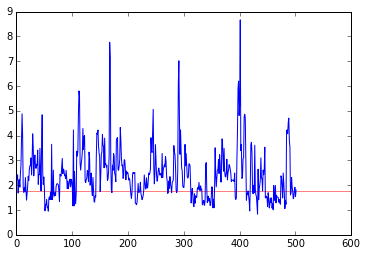


 Cycle number : 2

Lowest Energy 1.06627128114 Sequence ['K', 'C', 'K', 'C', 'I']



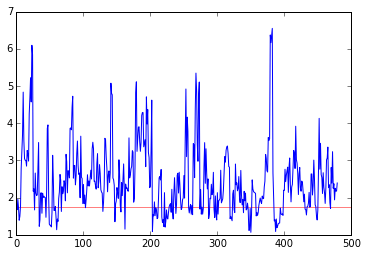


 Cycle number : 3

Lowest Energy 0.925221803476 Sequence ['A', 'E', 'A', 'C', 'P']



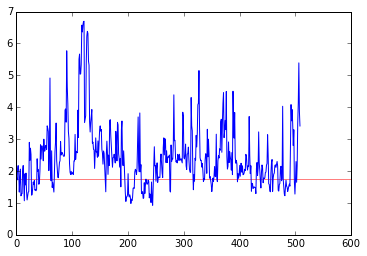


 Cycle number : 4

Lowest Energy 0.95994434707 Sequence ['A', 'E', 'C', 'G', 'M']



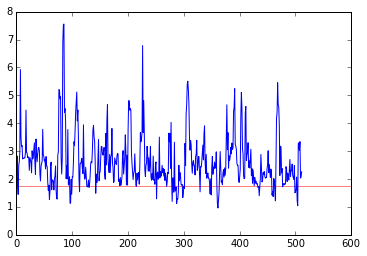


 Cycle number : 5

Lowest Energy 0.955434881015 Sequence ['K', 'E', 'P', 'N', 'T']



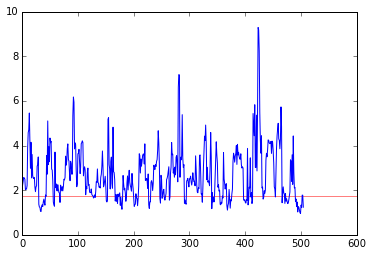

In [202]:
results6_bis = run_mc(1000,test_peptide3, temp=1.0, nb_cycles=5, plot=True,verbose = False)

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 3.51197490234 Sequence ['L', 'Q', 'A', 'A', 'G']



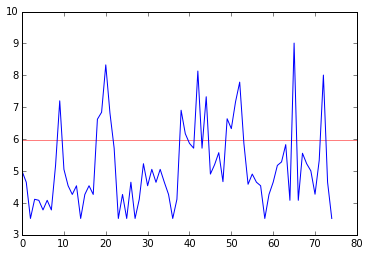


 Cycle number : 2

Lowest Energy 3.51197490234 Sequence ['L', 'Q', 'A', 'A', 'G']



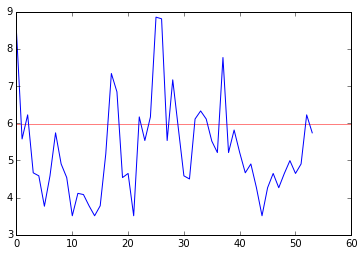


 Cycle number : 3

Lowest Energy 3.51197490234 Sequence ['L', 'Q', 'A', 'A', 'G']



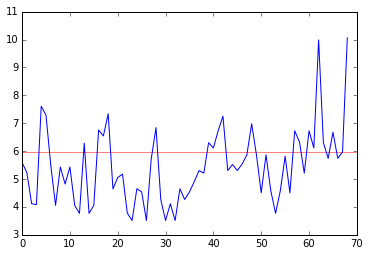


 Cycle number : 4

Lowest Energy 3.7678383127 Sequence ['L', 'Q', 'D', 'A', 'I']



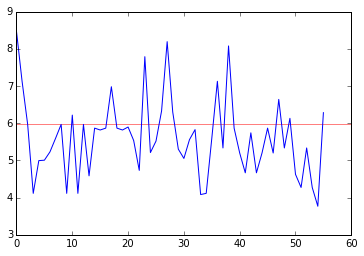


 Cycle number : 5

Lowest Energy 3.51197490234 Sequence ['L', 'Q', 'A', 'A', 'G']



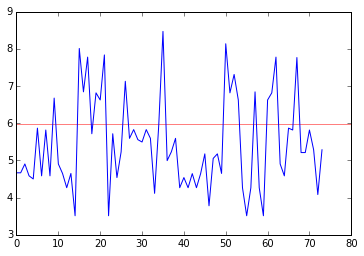

In [203]:
results_random = run_mc(1000,PDZ_Data.peptides[46], temp=1.0, nb_cycles = 5, plot=True, verbose = False)

Interesting, another peptide which doesnt like its sequence being changed at all. Lets try to do this for all the peptides in the database and trace the variation of energy for each of them.

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 0.951357470424 Sequence ['P', 'H', 'Y', 'D', 'V']



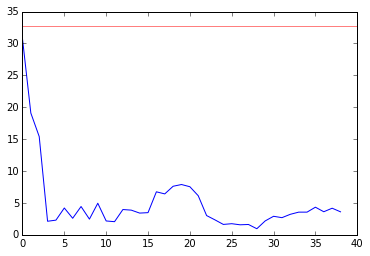

Name of Peptide APC
Base Energy 108.837975035
Base Sequence ['L', 'V', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.22749771693 Sequence ['A', 'G', 'R', 'D', 'V']



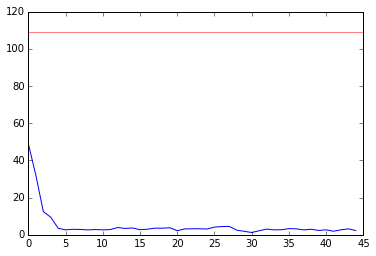

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 8.58429959615 Sequence ['V', 'L', 'P', 'G', 'I']



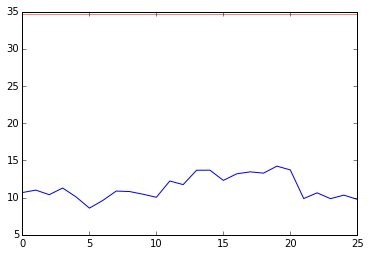

Name of Peptide ASIC2
Base Energy 2.58576358448
Base Sequence ['E', 'E', 'I', 'A', 'C']

 Cycle number : 1

Lowest Energy 1.07247965874 Sequence ['P', 'E', 'C', 'G', 'Q']



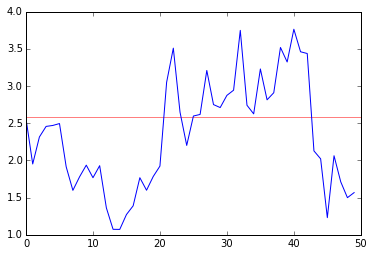

Name of Peptide Caspr2
Base Energy 10.2327578819
Base Sequence ['K', 'E', 'W', 'L', 'I']

 Cycle number : 1

Lowest Energy 5.14862515716 Sequence ['G', 'E', 'W', 'L', 'A']



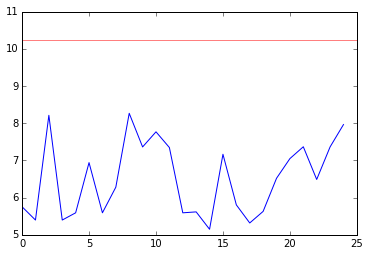

Name of Peptide Cav2.2
Base Energy 7.8158107556
Base Sequence ['Q', 'D', 'H', 'W', 'C']

 Cycle number : 1

Lowest Energy 1.49909057977 Sequence ['G', 'H', 'Q', 'T', 'R']



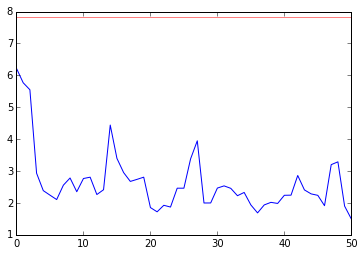

Name of Peptide Cftr
Base Energy 10.1187576025
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 15.3941785133 Sequence ['Q', 'E', 'T', 'R', 'G']



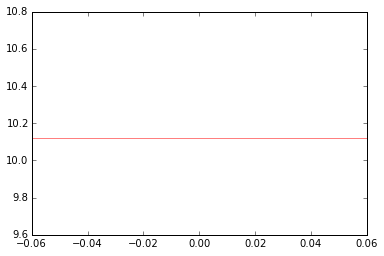

Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 0.95088457604 Sequence ['P', 'E', 'A', 'G', 'N']



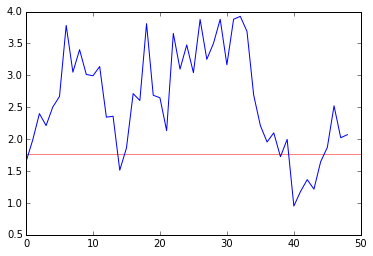

Name of Peptide Claudin1
Base Energy 24.338085902
Base Sequence ['G', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.69224698356 Sequence ['C', 'C', 'G', 'Y', 'P']



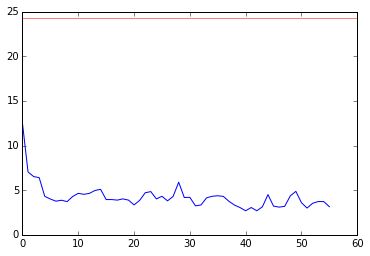

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 9.87520248928 Sequence ['K', 'E', 'T', 'H', 'V']



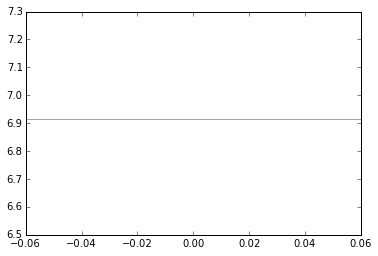

Name of Peptide Connexin43
Base Energy 5.88006436035
Base Sequence ['D', 'D', 'L', 'E', 'I']

 Cycle number : 1

Lowest Energy 4.88854791543 Sequence ['K', 'D', 'L', 'E', 'M']



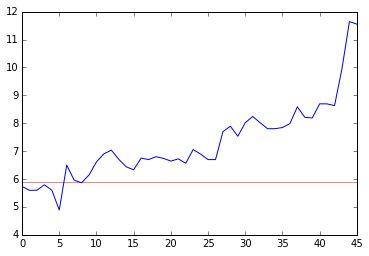

Name of Peptide CRIPT
Base Energy 15.9107823407
Base Sequence ['K', 'Q', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 17.1010792933 Sequence ['H', 'Q', 'T', 'S', 'V']



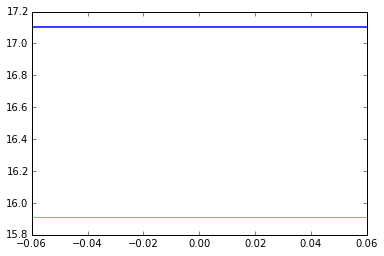

Name of Peptide CtBP1
Base Energy 25.6643013809
Base Sequence ['T', 'S', 'D', 'Q', 'L']

 Cycle number : 1

Lowest Energy 0.923686321323 Sequence ['P', 'E', 'G', 'G', 'Y']



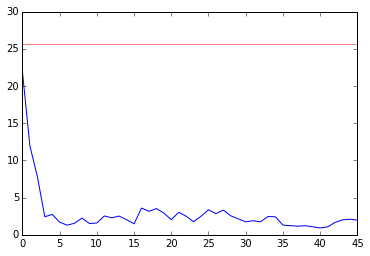

Name of Peptide Dlgap123
Base Energy 7.07795685126
Base Sequence ['A', 'Q', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 4.15234463806 Sequence ['A', 'Q', 'T', 'R', 'F']



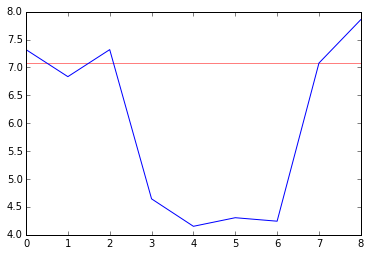

Name of Peptide EphA71
Base Energy 2.55142344213
Base Sequence ['T', 'G', 'I', 'Q', 'V']

 Cycle number : 1

Lowest Energy 1.53738403459 Sequence ['T', 'E', 'L', 'Q', 'V']



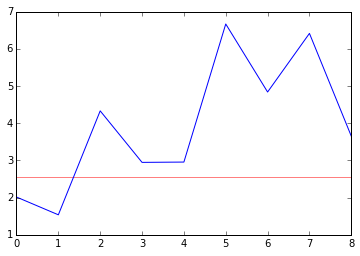

Name of Peptide EphB2
Base Energy 11.4576849544
Base Sequence ['Q', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 2.49277719823 Sequence ['I', 'S', 'Q', 'D', 'H']



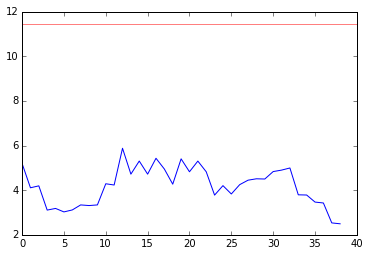

Name of Peptide EphrinB12
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.58962010049 Sequence ['A', 'Y', 'Y', 'D', 'I']



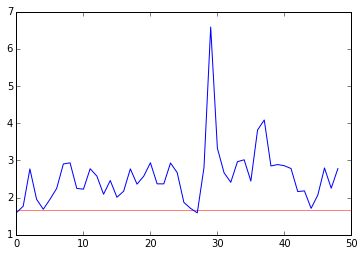

Name of Peptide ErbB4
Base Energy 4.5055182776
Base Sequence ['T', 'A', 'E', 'M', 'F']

 Cycle number : 1

Lowest Energy 1.32469828863 Sequence ['G', 'Q', 'E', 'M', 'M']



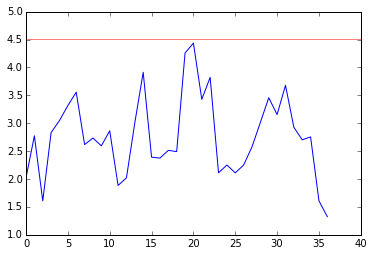

Name of Peptide Frizzled
Base Energy 28.4843578527
Base Sequence ['G', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 20.2837792153 Sequence ['T', 'E', 'T', 'T', 'C']



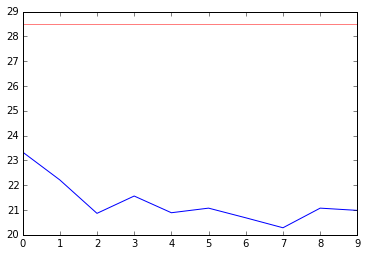

Name of Peptide GluR1
Base Energy 7.08075331182
Base Sequence ['G', 'A', 'T', 'G', 'L']

 Cycle number : 1

Lowest Energy 1.6670082455 Sequence ['N', 'A', 'T', 'L', 'W']



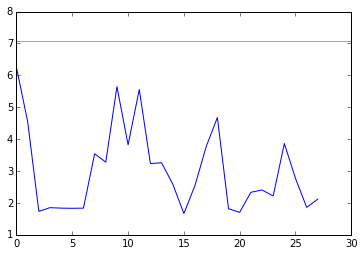

Name of Peptide GluR2_1
Base Energy 8.96655307331
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.29849487454 Sequence ['P', 'C', 'M', 'K', 'V']



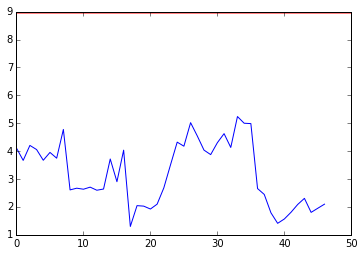

Name of Peptide GluR5_1
Base Energy 28.5435975345
Base Sequence ['K', 'E', 'T', 'V', 'A']

 Cycle number : 1

Lowest Energy 6.03107744533 Sequence ['K', 'E', 'R', 'C', 'I']



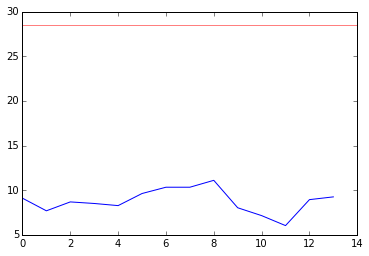

Name of Peptide GlycphrinC
Base Energy 55.5078676101
Base Sequence ['K', 'E', 'Y', 'F', 'I']

 Cycle number : 1

Lowest Energy 1.96018799362 Sequence ['K', 'E', 'R', 'Q', 'M']



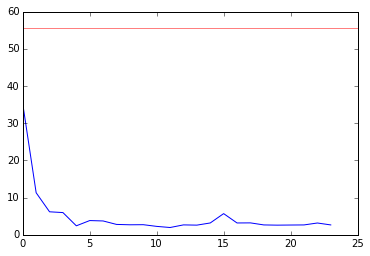

Name of Peptide GRK6
Base Energy 18.068508857
Base Sequence ['L', 'P', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 9.66883475289 Sequence ['R', 'P', 'T', 'R', 'W']



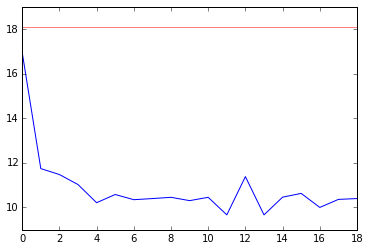

Name of Peptide Htr2c
Base Energy 5.87031674462
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 3.65333743848 Sequence ['H', 'L', 'S', 'N', 'V']



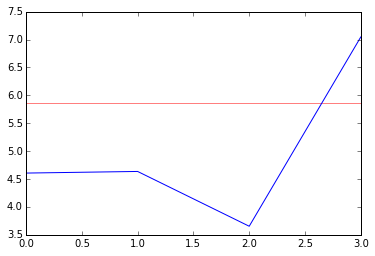

Name of Peptide JAM-1
Base Energy 6.36765080863
Base Sequence ['S', 'S', 'F', 'L', 'V']

 Cycle number : 1

Lowest Energy 1.06453453995 Sequence ['I', 'S', 'H', 'T', 'A']



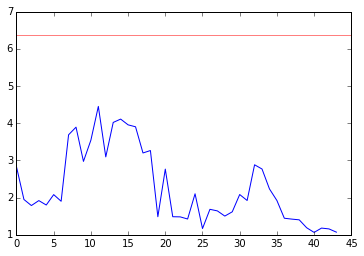

Name of Peptide KIF17
Base Energy 4.01838283588
Base Sequence ['G', 'G', 'E', 'P', 'L']

 Cycle number : 1

Lowest Energy 1.64142722946 Sequence ['K', 'A', 'M', 'T', 'T']



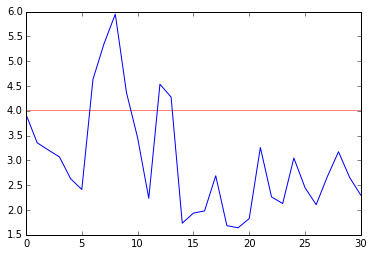

Name of Peptide KIF1B
Base Energy 26.4271991025
Base Sequence ['R', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 10.9260650216 Sequence ['R', 'Q', 'T', 'T', 'D']



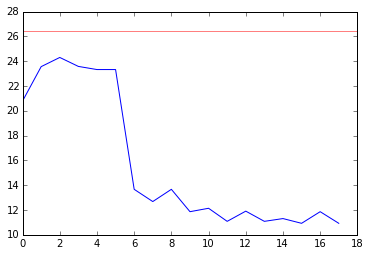

Name of Peptide Kir2.1
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 5.85363417453 Sequence ['R', 'E', 'R', 'A', 'Y']



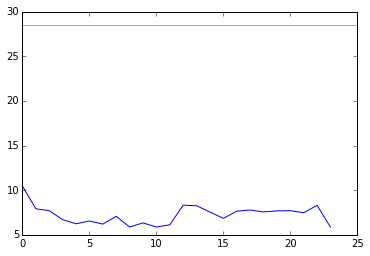

Name of Peptide Kv1.4
Base Energy 49.9055472783
Base Sequence ['V', 'E', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 15.7043748216 Sequence ['G', 'E', 'T', 'D', 'C']



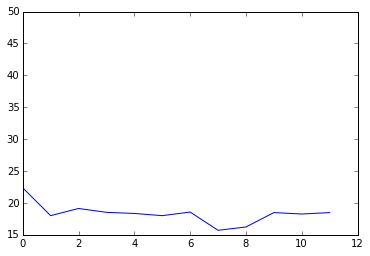

Name of Peptide Lgltminase
Base Energy 4.54834097666
Base Sequence ['L', 'E', 'S', 'M', 'V']

 Cycle number : 1

Lowest Energy 3.12916296651 Sequence ['N', 'E', 'S', 'M', 'V']



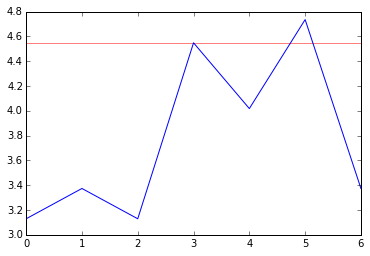

Name of Peptide Liprin2
Base Energy 7.84514190615
Base Sequence ['R', 'T', 'Y', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.27170971552 Sequence ['I', 'E', 'G', 'G', 'R']



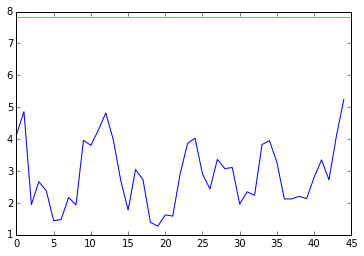

Name of Peptide Megalin
Base Energy 6.7113293881
Base Sequence ['E', 'D', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 5.05456677768 Sequence ['H', 'D', 'S', 'D', 'V']



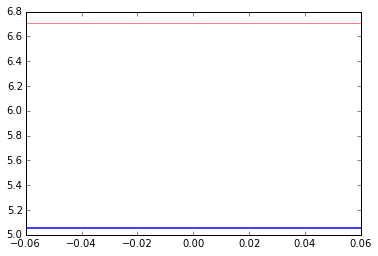

Name of Peptide Mel1a/b
Base Energy 17.76549867
Base Sequence ['K', 'V', 'D', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.68867948312 Sequence ['K', 'V', 'K', 'G', 'C']



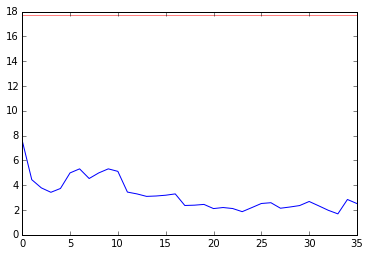

Name of Peptide mGluR3
Base Energy 10.059792039
Base Sequence ['T', 'T', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 8.54172438744 Sequence ['T', 'N', 'T', 'G', 'N']



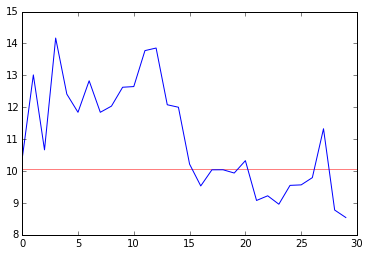

Name of Peptide ctransprtr
Base Energy 3.70916853858
Base Sequence ['N', 'A', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 4.03668225093 Sequence ['N', 'F', 'T', 'R', 'L']



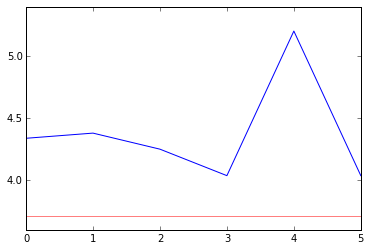

Name of Peptide Nav1.4
Base Energy 18.1065927851
Base Sequence ['K', 'E', 'S', 'L', 'V']

 Cycle number : 1

Lowest Energy 19.6518896967 Sequence ['K', 'E', 'S', 'I', 'V']



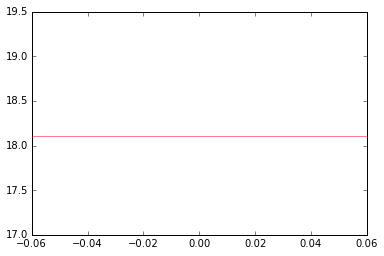

Name of Peptide Nav1.5
Base Energy 19.5874496371
Base Sequence ['R', 'E', 'S', 'I', 'V']

 Cycle number : 1

Lowest Energy 16.3915995181 Sequence ['R', 'E', 'S', 'E', 'I']



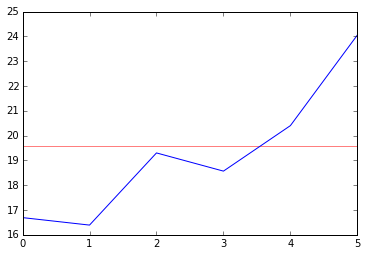

Name of Peptide Neurxin1/2
Base Energy 34.7545858124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 8.33856447371 Sequence ['Q', 'D', 'Y', 'F', 'D']



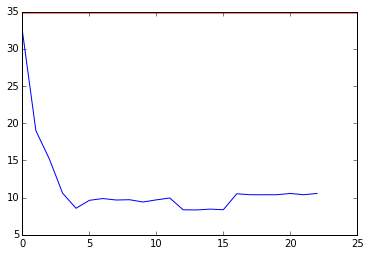

Name of Peptide NMDAR2A
Base Energy 24.0655913503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 3.94727918265 Sequence ['I', 'E', 'S', 'D', 'H']



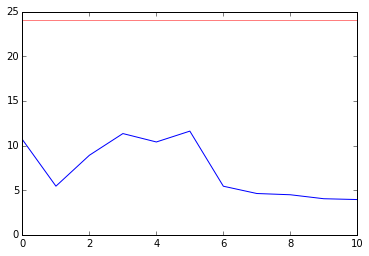

Name of Peptide NMDAR2B
Base Energy 17.5025963503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 6.84591733263 Sequence ['I', 'E', 'R', 'D', 'V']



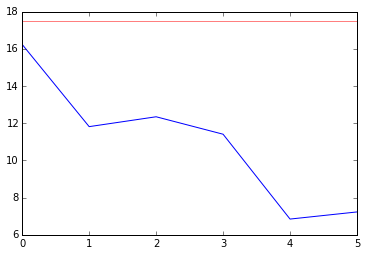

Name of Peptide P2Y1
Base Energy 28.625230555
Base Sequence ['G', 'D', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 14.6295119814 Sequence ['D', 'D', 'T', 'D', 'G']



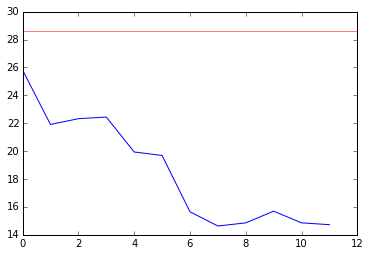

Name of Peptide Parkin
Base Energy 2.06541536473
Base Sequence ['H', 'W', 'F', 'D', 'V']

 Cycle number : 1

Lowest Energy 0.937032039283 Sequence ['H', 'W', 'K', 'D', 'V']



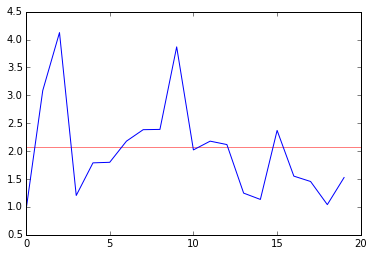

Name of Peptide PDGFR
Base Energy 14.6647382588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 0.936634779079 Sequence ['W', 'H', 'E', 'N', 'A']



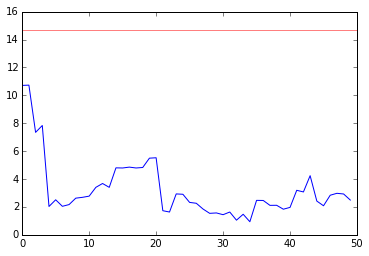

Name of Peptide PFK-M
Base Energy 15.2354145009
Base Sequence ['G', 'E', 'A', 'A', 'V']

 Cycle number : 1

Lowest Energy 1.48216069785 Sequence ['R', 'P', 'Q', 'A', 'Q']



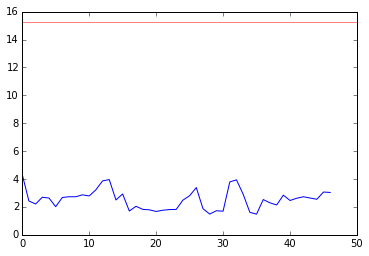

Name of Peptide PIX
Base Energy 27.0731044414
Base Sequence ['D', 'E', 'T', 'N', 'L']

 Cycle number : 1

Lowest Energy 6.78915632803 Sequence ['D', 'E', 'T', 'N', 'Y']



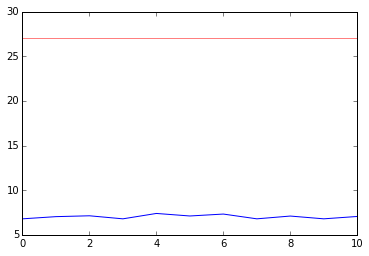

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 4.66635894802 Sequence ['L', 'Q', 'C', 'A', 'V']



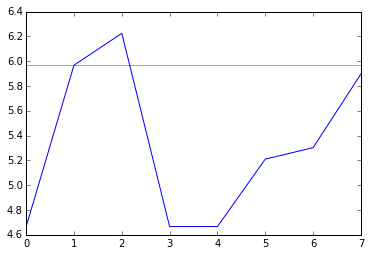

Name of Peptide PMCA1
Base Energy 30.2193108669
Base Sequence ['L', 'E', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 14.4092047079 Sequence ['E', 'E', 'T', 'S', 'L']



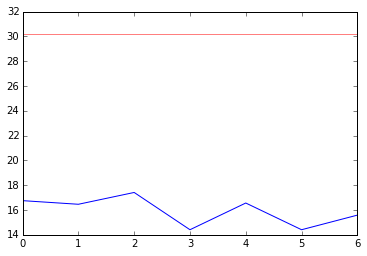

Name of Peptide Ril
Base Energy 31.9187527305
Base Sequence ['K', 'V', 'E', 'L', 'V']

 Cycle number : 1

Lowest Energy 9.9514520154 Sequence ['D', 'L', 'E', 'M', 'H']



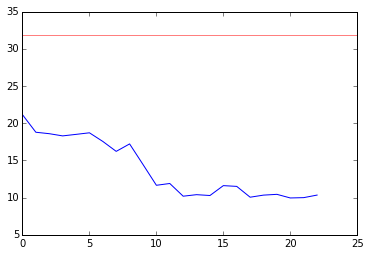

Name of Peptide Sapk3
Base Energy 25.7589244175
Base Sequence ['K', 'E', 'T', 'A', 'L']

 Cycle number : 1

Lowest Energy 9.46431945775 Sequence ['P', 'E', 'T', 'A', 'P']



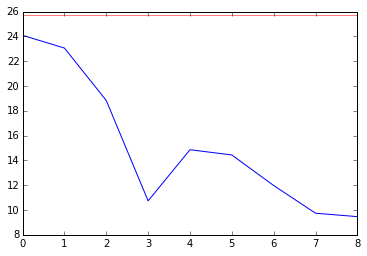

Name of Peptide SSTR2
Base Energy 8.04013252582
Base Sequence ['I', 'I', 'A', 'W', 'V']

 Cycle number : 1

Lowest Energy 8.04013252582 Sequence ['I', 'I', 'A', 'W', 'V']



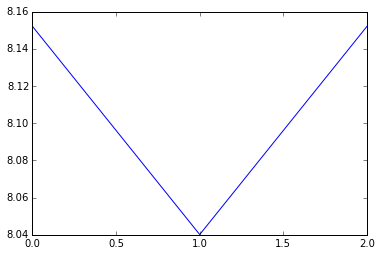

Name of Peptide Stargazin
Base Energy 19.2404872197
Base Sequence ['R', 'T', 'T', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.63878064495 Sequence ['R', 'T', 'K', 'P', 'V']



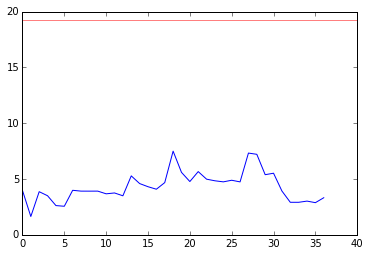

Name of Peptide Syndecan1
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 0.933829446802 Sequence ['H', 'E', 'Q', 'G', 'A']



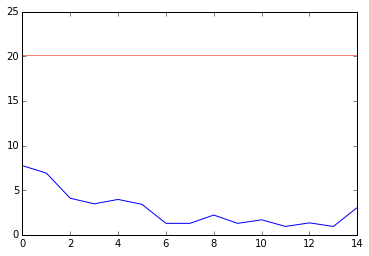

Name of Peptide Syndecan2
Base Energy 36.8856289754
Base Sequence ['K', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 2.69796092814 Sequence ['A', 'A', 'A', 'G', 'A']



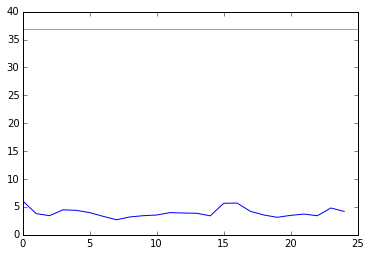

Name of Peptide TAZ
Base Energy 17.1937505167
Base Sequence ['F', 'L', 'T', 'W', 'L']

 Cycle number : 1

Lowest Energy 6.68870054429 Sequence ['F', 'G', 'T', 'W', 'M']



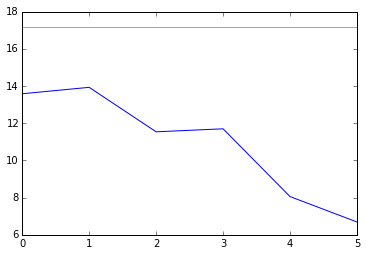

Name of Peptide Trip6
Base Energy 21.3116037858
Base Sequence ['V', 'T', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 1.46171781898 Sequence ['A', 'P', 'K', 'N', 'V']



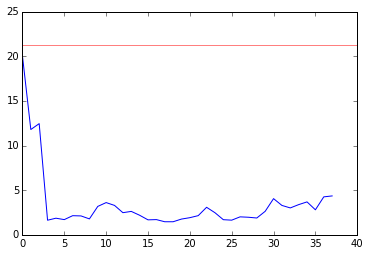

Name of Peptide TRPC4
Base Energy 3.49309391044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 1.72242653179 Sequence ['N', 'T', 'T', 'R', 'A']



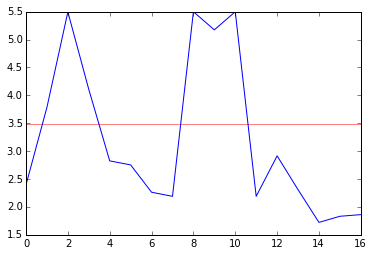

Name of Peptide AcvR1
Base Energy 8.1782910361
Base Sequence ['L', 'K', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 1.27223816235 Sequence ['R', 'H', 'Q', 'D', 'K']



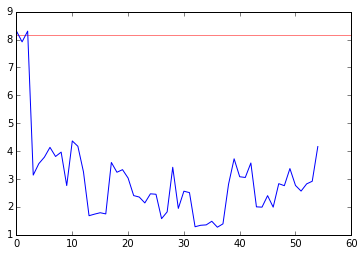

Name of Peptide AcvR2
Base Energy 28.2894100244
Base Sequence ['K', 'E', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 12.4016516449 Sequence ['P', 'E', 'C', 'S', 'I']



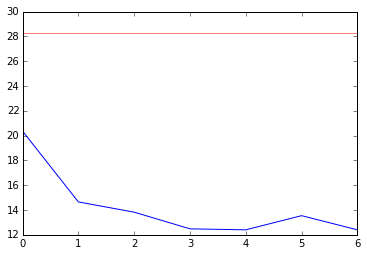

Name of Peptide AcvR2b
Base Energy 36.0467473257
Base Sequence ['K', 'E', 'S', 'S', 'I']

 Cycle number : 1

Lowest Energy 9.94038417428 Sequence ['H', 'E', 'P', 'S', 'L']



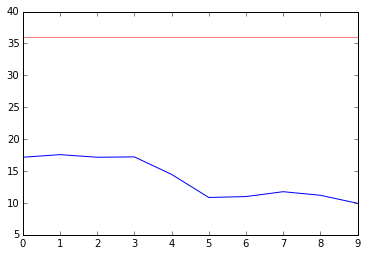

Name of Peptide Cacna1a
Base Energy 17.1905846257
Base Sequence ['E', 'D', 'D', 'W', 'C']

 Cycle number : 1

Lowest Energy 2.49379546431 Sequence ['A', 'D', 'D', 'T', 'C']



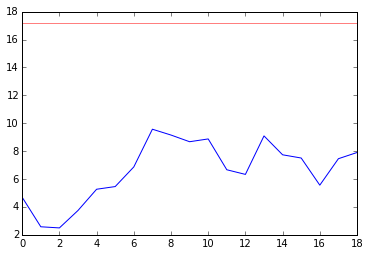

Name of Peptide Cav1.2
Base Energy 54.0718184806
Base Sequence ['Y', 'V', 'S', 'N', 'L']

 Cycle number : 1

Lowest Energy 1.81400874559 Sequence ['Y', 'M', 'P', 'N', 'L']



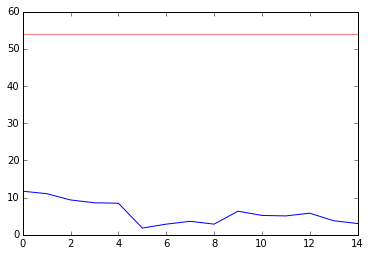

Name of Peptide Cav2.3
Base Energy 4.74582296906
Base Sequence ['E', 'D', 'D', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.06818253727 Sequence ['A', 'E', 'A', 'S', 'P']



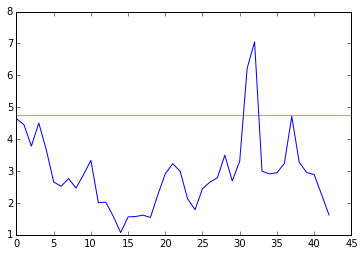

Name of Peptide Cav3.2
Base Energy 2.13818288188
Base Sequence ['G', 'D', 'E', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.43507879982 Sequence ['G', 'D', 'Q', 'P', 'I']



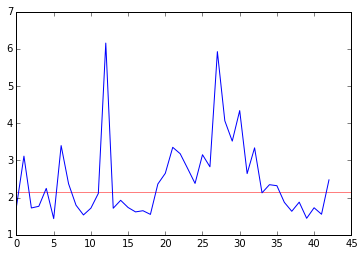

Name of Peptide ITPR3
Base Energy 3.90395331342
Base Sequence ['N', 'C', 'M', 'S', 'R']

 Cycle number : 1

Lowest Energy 1.46835779318 Sequence ['H', 'E', 'P', 'S', 'Q']



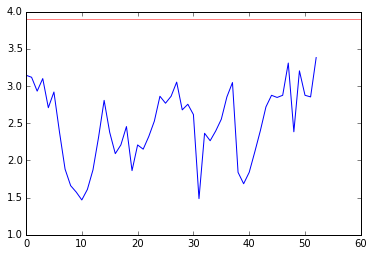

Name of Peptide RYR2
Base Energy 4.81261114343
Base Sequence ['E', 'D', 'Q', 'L', 'N']

 Cycle number : 1

Lowest Energy 1.33421239388 Sequence ['H', 'D', 'E', 'D', 'C']



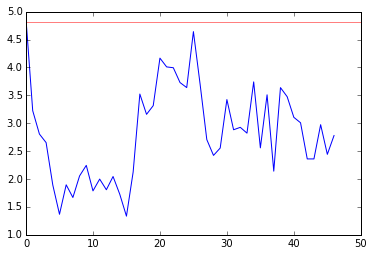

Name of Peptide SERCA1
Base Energy 13.7805269613
Base Sequence ['N', 'Y', 'L', 'E', 'G']

 Cycle number : 1

Lowest Energy 1.36910871529 Sequence ['A', 'H', 'S', 'T', 'C']



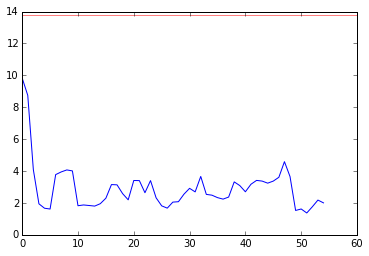

Name of Peptide SERCA2A
Base Energy 5.04661264325
Base Sequence ['P', 'A', 'I', 'L', 'E']

 Cycle number : 1

Lowest Energy 1.63156938275 Sequence ['R', 'P', 'C', 'G', 'Q']



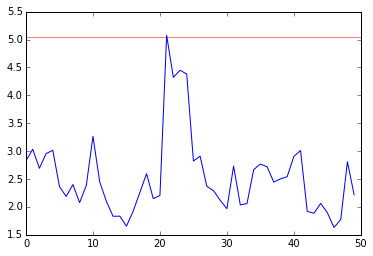

Name of Peptide SERCA3
Base Energy 6.2704518053
Base Sequence ['V', 'W', 'P', 'S', 'D']

 Cycle number : 1

Lowest Energy 1.50194239407 Sequence ['V', 'E', 'Q', 'S', 'K']



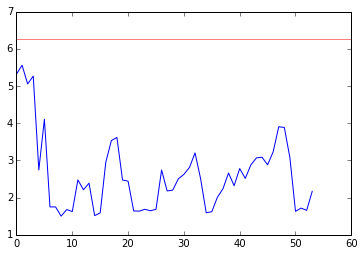

Name of Peptide TPC1
Base Energy 8.92322025265
Base Sequence ['S', 'Q', 'T', 'V', 'T']

 Cycle number : 1

Lowest Energy 1.32229516979 Sequence ['C', 'E', 'H', 'M', 'C']



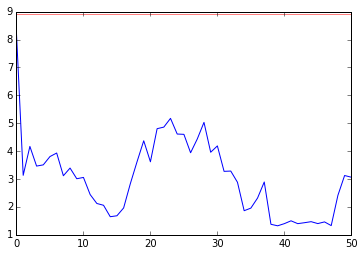

Name of Peptide Claudin2
Base Energy 11.3170000173
Base Sequence ['L', 'T', 'G', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.72403588823 Sequence ['P', 'T', 'R', 'Y', 'I']



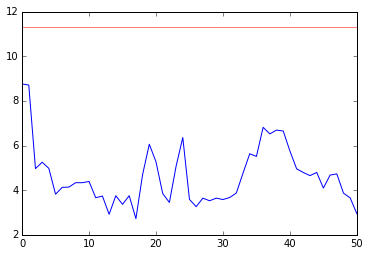

Name of Peptide Claudin3
Base Energy 7.17366012465
Base Sequence ['R', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.02114277376 Sequence ['P', 'K', 'D', 'W', 'L']



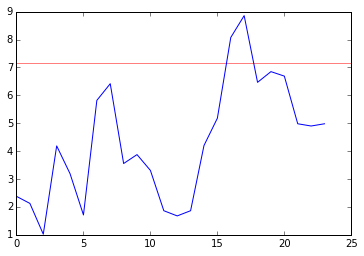

Name of Peptide Claudin4
Base Energy 9.66498096644
Base Sequence ['A', 'S', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.31180574607 Sequence ['C', 'S', 'T', 'Y', 'N']



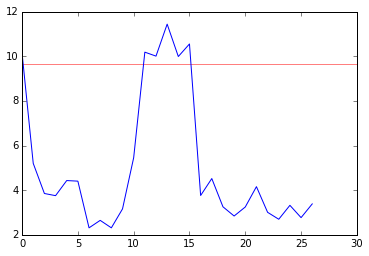

Name of Peptide Claudin5
Base Energy 69.1904204791
Base Sequence ['K', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.38144023707 Sequence ['H', 'H', 'N', 'T', 'N']



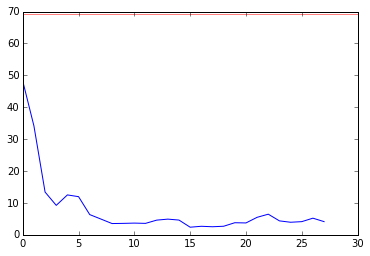

Name of Peptide Claudin6
Base Energy 52.2853897426
Base Sequence ['T', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.7056327965 Sequence ['W', 'K', 'Q', 'E', 'K']



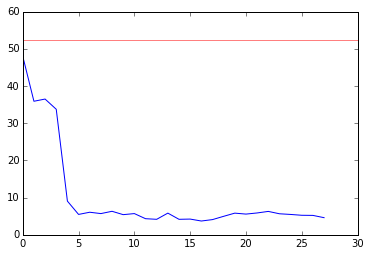

Name of Peptide Claudin7
Base Energy 14.8914186154
Base Sequence ['S', 'K', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.58330112635 Sequence ['A', 'K', 'A', 'N', 'M']



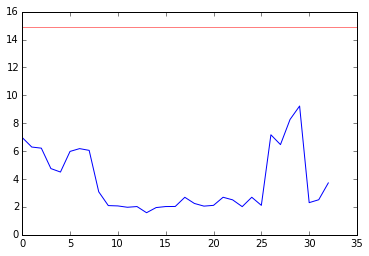

Name of Peptide Claudin8
Base Energy 7.60195464094
Base Sequence ['K', 'S', 'Q', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.32992095438 Sequence ['A', 'S', 'Q', 'Y', 'V']



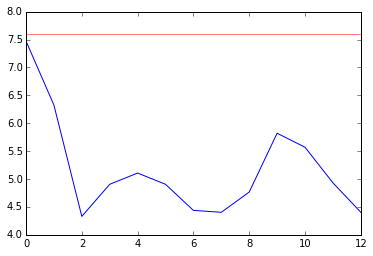

Name of Peptide Claudin9
Base Energy 13.0920258928
Base Sequence ['K', 'R', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.27530170364 Sequence ['R', 'Q', 'K', 'Y', 'L']



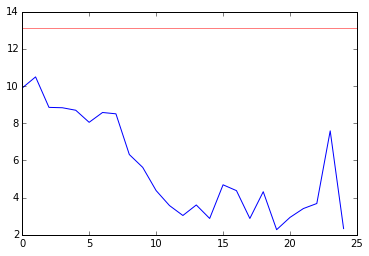

Name of Peptide Claudin10
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.38377425744 Sequence ['V', 'E', 'A', 'Y', 'N']



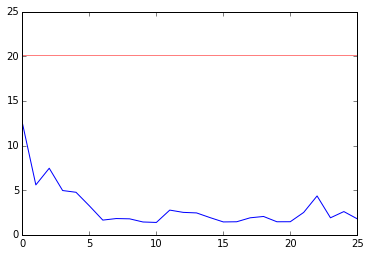

Name of Peptide Claudin11
Base Energy 19.3286831196
Base Sequence ['K', 'S', 'A', 'H', 'V']

 Cycle number : 1

Lowest Energy 1.68818820241 Sequence ['K', 'F', 'A', 'H', 'D']



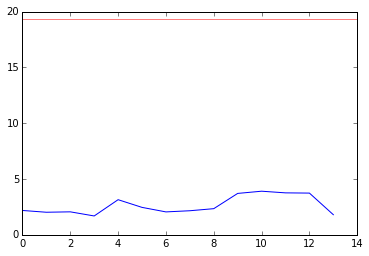

Name of Peptide Claudin13
Base Energy 5.36008828371
Base Sequence ['D', 'T', 'L', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.03479874759 Sequence ['P', 'H', 'G', 'D', 'G']



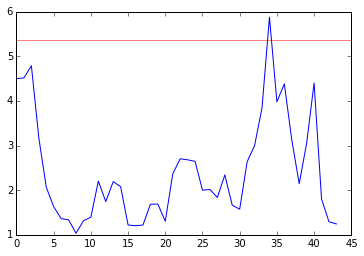

Name of Peptide Claudin14
Base Energy 1.69869817987
Base Sequence ['L', 'N', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.70713668617 Sequence ['L', 'N', 'N', 'Y', 'V']



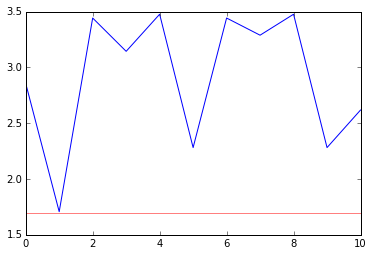

Name of Peptide Claudin15
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.66340414887 Sequence ['I', 'D', 'A', 'Y', 'M']



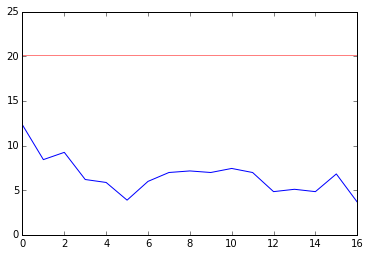

Name of Peptide Claudin16
Base Energy 33.1307825301
Base Sequence ['V', 'D', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 3.39067668605 Sequence ['N', 'N', 'N', 'R', 'F']



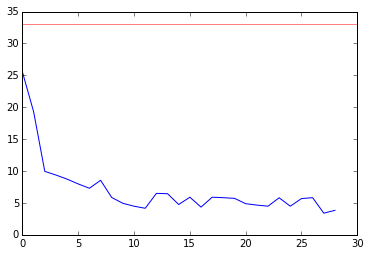

Name of Peptide Claudin18
Base Energy 29.3482977089
Base Sequence ['K', 'Y', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.66705517044 Sequence ['K', 'H', 'P', 'C', 'V']



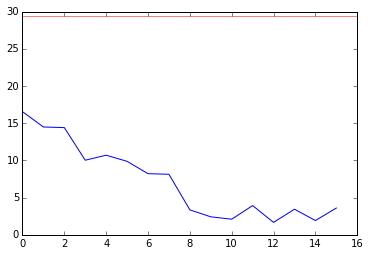

Name of Peptide Claudin19
Base Energy 4.89381545106
Base Sequence ['A', 'R', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.0741280098 Sequence ['G', 'R', 'Q', 'D', 'I']



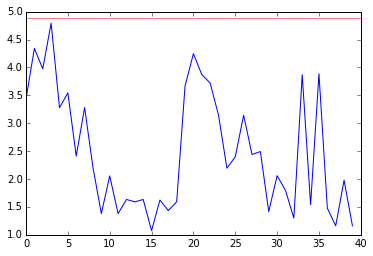

Name of Peptide Claudin22
Base Energy 2.30310124649
Base Sequence ['A', 'N', 'P', 'E', 'I']

 Cycle number : 1

Lowest Energy 1.44656316567 Sequence ['P', 'H', 'G', 'N', 'M']



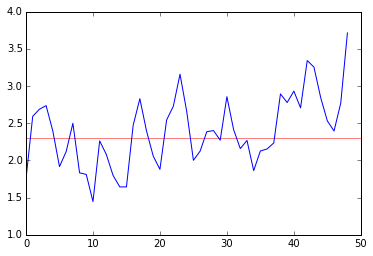

Name of Peptide Claudin23
Base Energy 2.47978086236
Base Sequence ['C', 'D', 'S', 'D', 'L']

 Cycle number : 1

Lowest Energy 1.70904073672 Sequence ['C', 'D', 'S', 'D', 'F']



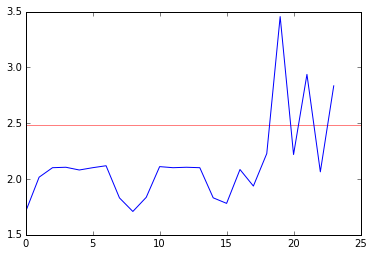

Name of Peptide EphrinB3
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.15706246266 Sequence ['K', 'Y', 'H', 'T', 'K']



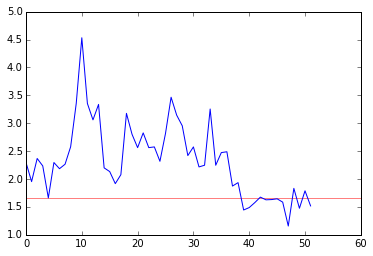

Name of Peptide GluR2_2
Base Energy 8.59842602681
Base Sequence ['V', 'T', 'D', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.31495838722 Sequence ['L', 'E', 'G', 'C', 'T']



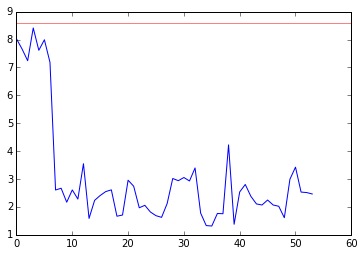

Name of Peptide GluR2_3
Base Energy 6.26261640287
Base Sequence ['L', 'G', 'W', 'V', 'E']

 Cycle number : 1

Lowest Energy 1.25326089214 Sequence ['K', 'D', 'P', 'N', 'E']



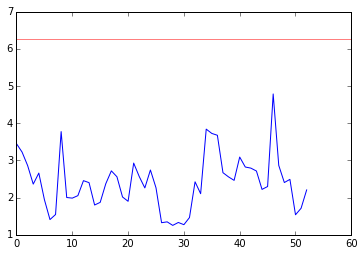

Name of Peptide GluR3
Base Energy 20.4335030733
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.37290403818 Sequence ['H', 'P', 'S', 'T', 'N']



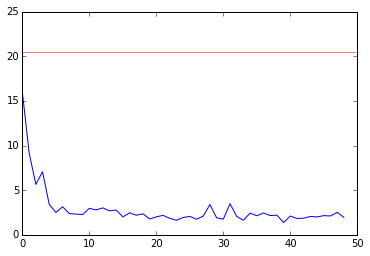

Name of Peptide GluR5_2
Base Energy 31.6788017701
Base Sequence ['S', 'V', 'H', 'T', 'V']

 Cycle number : 1

Lowest Energy 1.14248502479 Sequence ['H', 'E', 'H', 'K', 'K']



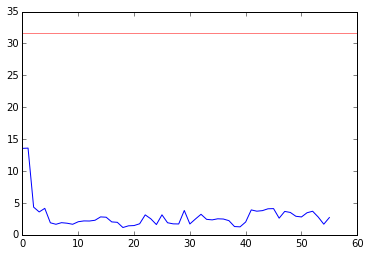

Name of Peptide GluRdelta1
Base Energy 30.759492334
Base Sequence ['H', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 6.51836919972 Sequence ['H', 'N', 'T', 'A', 'K']



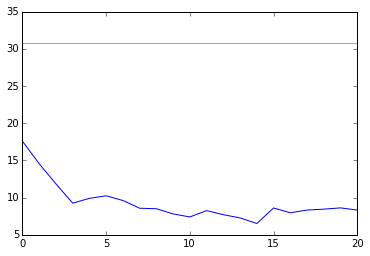

Name of Peptide GluRdelta2
Base Energy 23.7971790916
Base Sequence ['R', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 4.35089708838 Sequence ['R', 'S', 'T', 'S', 'H']



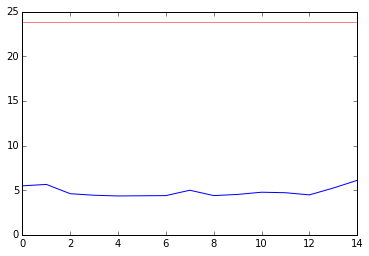

Name of Peptide KA-2
Base Energy 12.6744224267
Base Sequence ['L', 'T', 'E', 'H', 'E']

 Cycle number : 1

Lowest Energy 1.66259980275 Sequence ['P', 'C', 'E', 'A', 'E']



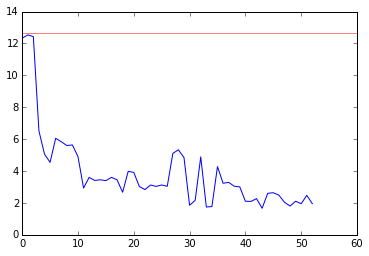

Name of Peptide mGluR1
Base Energy 15.8797011742
Base Sequence ['S', 'S', 'S', 'T', 'L']

 Cycle number : 1

Lowest Energy 3.90112887583 Sequence ['D', 'H', 'C', 'S', 'I']



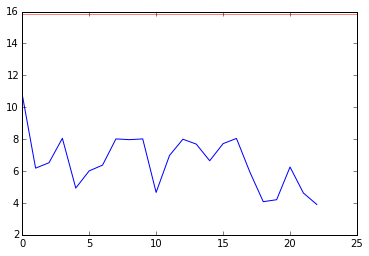

Name of Peptide NMDAR1
Base Energy 1.99695789843
Base Sequence ['R', 'H', 'R', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.26576652273 Sequence ['K', 'E', 'Q', 'P', 'Q']



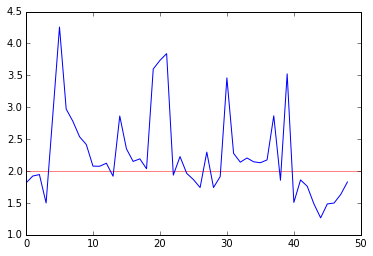

Name of Peptide NMDAR2C
Base Energy 29.899606913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 11.2476536162 Sequence ['L', 'E', 'K', 'E', 'I']



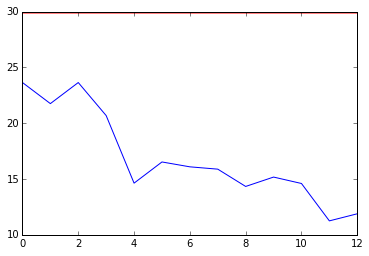

Name of Peptide NMDAR2D
Base Energy 22.839446913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 9.33148419256 Sequence ['L', 'E', 'S', 'E', 'G']



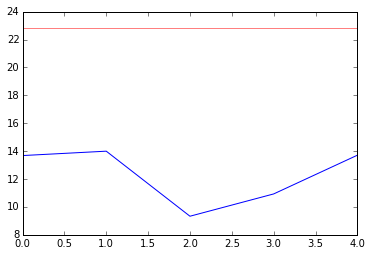

In [204]:
for i in range(100):
    results = run_mc(100, PDZ_Data.peptides[i], temp=1.0,nb_cycles = 1, plot=True, verbose=False)

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 1.77751425092 Sequence ['P', 'M', 'A', 'H', 'F']



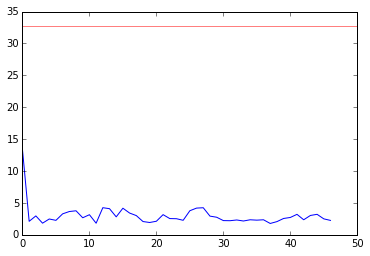

Name of Peptide APC
Base Energy 108.837975035
Base Sequence ['L', 'V', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.22023359698 Sequence ['K', 'H', 'K', 'T', 'T']



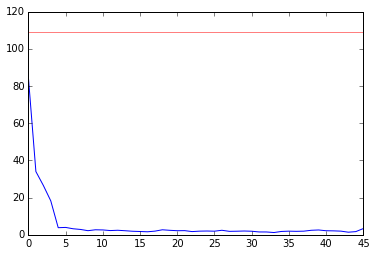

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 2.39694578741 Sequence ['L', 'N', 'A', 'T', 'F']



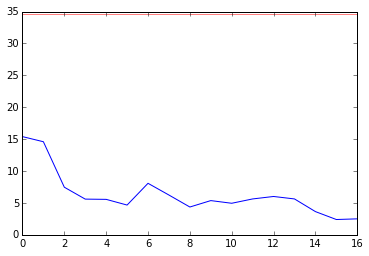

Name of Peptide ASIC2
Base Energy 2.58576358448
Base Sequence ['E', 'E', 'I', 'A', 'C']

 Cycle number : 1

Lowest Energy 1.00767844036 Sequence ['R', 'P', 'P', 'D', 'I']



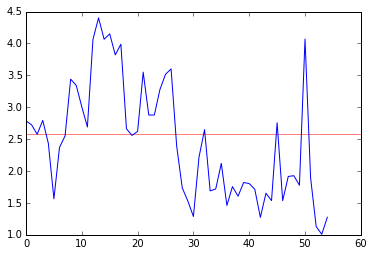

Name of Peptide Caspr2
Base Energy 10.2327578819
Base Sequence ['K', 'E', 'W', 'L', 'I']

 Cycle number : 1

Lowest Energy 4.73451067413 Sequence ['K', 'T', 'W', 'V', 'T']



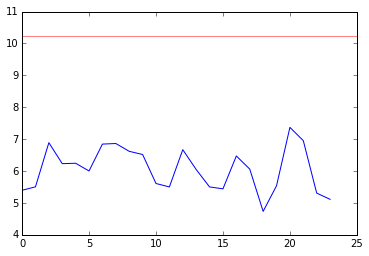

Name of Peptide Cav2.2
Base Energy 7.8158107556
Base Sequence ['Q', 'D', 'H', 'W', 'C']

 Cycle number : 1

Lowest Energy 1.31093719204 Sequence ['A', 'D', 'A', 'S', 'M']



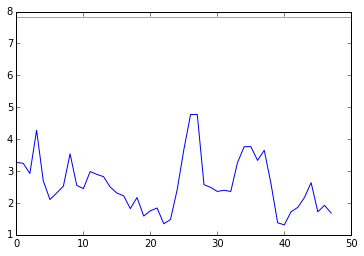

Name of Peptide Cftr
Base Energy 10.1187576025
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 10.9479228055 Sequence ['Q', 'E', 'T', 'R', 'I']



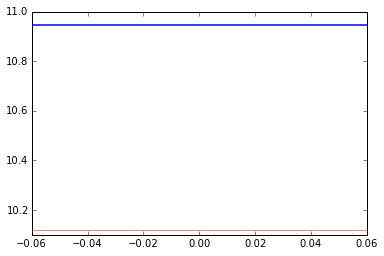

Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 1.58949563264 Sequence ['N', 'Q', 'E', 'D', 'W']



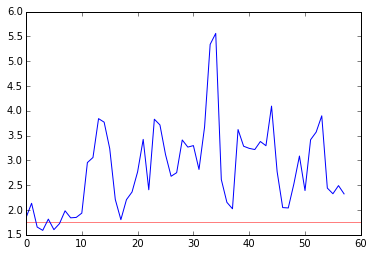

Name of Peptide Claudin1
Base Energy 24.338085902
Base Sequence ['G', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.08740436193 Sequence ['Q', 'E', 'K', 'Y', 'A']



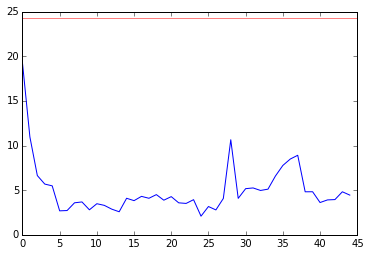

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 6.60122455223 Sequence ['L', 'E', 'T', 'H', 'V']



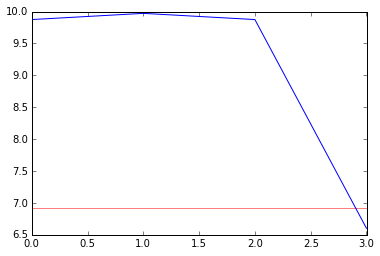

Name of Peptide Connexin43
Base Energy 5.88006436035
Base Sequence ['D', 'D', 'L', 'E', 'I']

 Cycle number : 1

Lowest Energy 5.24495894577 Sequence ['P', 'H', 'L', 'C', 'T']



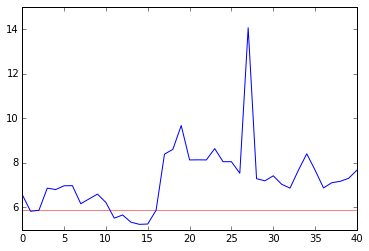

Name of Peptide CRIPT
Base Energy 15.9107823407
Base Sequence ['K', 'Q', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 17.1010792933 Sequence ['H', 'Q', 'T', 'S', 'V']



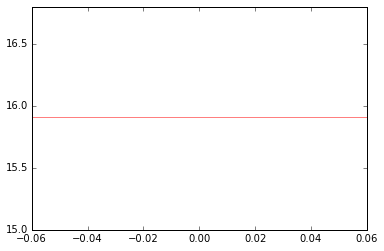

Name of Peptide CtBP1
Base Energy 25.6643013809
Base Sequence ['T', 'S', 'D', 'Q', 'L']

 Cycle number : 1

Lowest Energy 1.32595103432 Sequence ['W', 'E', 'K', 'G', 'D']



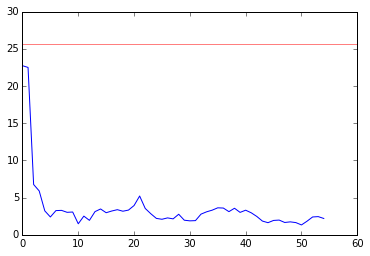

Name of Peptide Dlgap123
Base Energy 7.07795685126
Base Sequence ['A', 'Q', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 4.15234463806 Sequence ['A', 'Q', 'T', 'R', 'F']



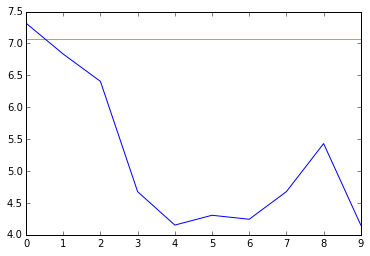

Name of Peptide EphA71
Base Energy 2.55142344213
Base Sequence ['T', 'G', 'I', 'Q', 'V']

 Cycle number : 1

Lowest Energy 2.02469333609 Sequence ['T', 'G', 'L', 'Q', 'V']



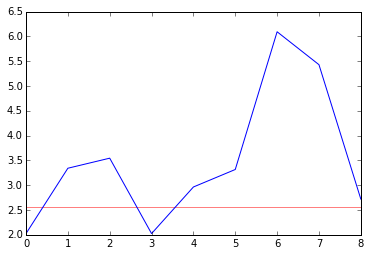

Name of Peptide EphB2
Base Energy 11.4576849544
Base Sequence ['Q', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 2.34945988509 Sequence ['I', 'S', 'Q', 'D', 'P']



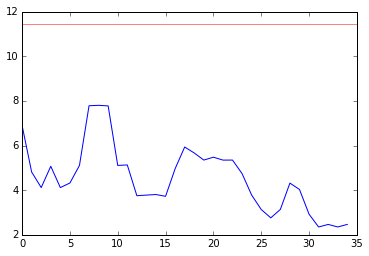

Name of Peptide EphrinB12
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.03693475136 Sequence ['P', 'G', 'H', 'G', 'V']



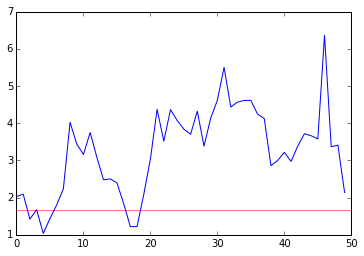

Name of Peptide ErbB4
Base Energy 4.5055182776
Base Sequence ['T', 'A', 'E', 'M', 'F']

 Cycle number : 1

Lowest Energy 1.16399376989 Sequence ['V', 'E', 'Q', 'M', 'C']



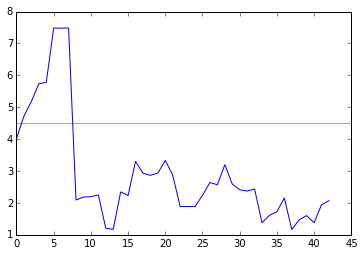

Name of Peptide Frizzled
Base Energy 28.4843578527
Base Sequence ['G', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 19.9012384165 Sequence ['G', 'D', 'T', 'T', 'V']



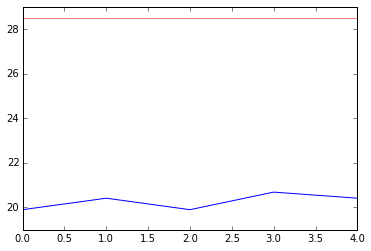

Name of Peptide GluR1
Base Energy 7.08075331182
Base Sequence ['G', 'A', 'T', 'G', 'L']

 Cycle number : 1

Lowest Energy 2.19265535826 Sequence ['P', 'H', 'S', 'R', 'W']



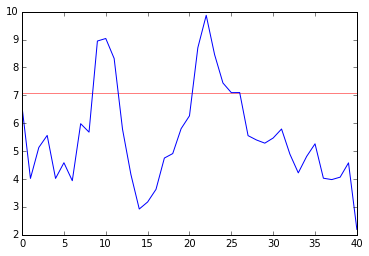

Name of Peptide GluR2_1
Base Energy 8.96655307331
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.41350349443 Sequence ['K', 'P', 'P', 'H', 'M']



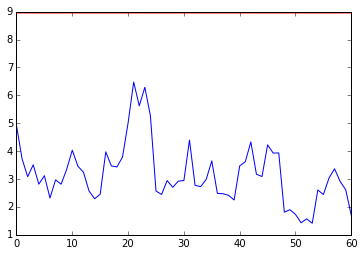

Name of Peptide GluR5_1
Base Energy 28.5435975345
Base Sequence ['K', 'E', 'T', 'V', 'A']

 Cycle number : 1

Lowest Energy 5.73292681048 Sequence ['W', 'E', 'P', 'A', 'G']



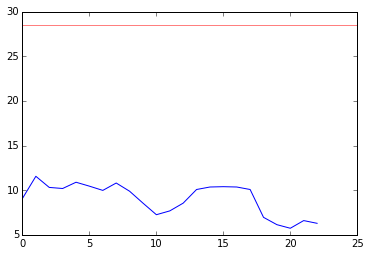

Name of Peptide GlycphrinC
Base Energy 55.5078676101
Base Sequence ['K', 'E', 'Y', 'F', 'I']

 Cycle number : 1

Lowest Energy 2.34387792103 Sequence ['K', 'E', 'R', 'Q', 'P']



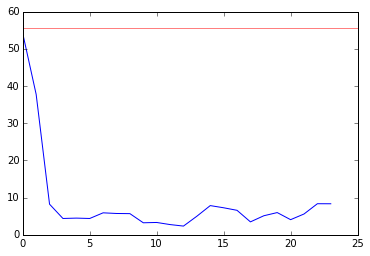

Name of Peptide GRK6
Base Energy 18.068508857
Base Sequence ['L', 'P', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 9.53275871704 Sequence ['R', 'P', 'T', 'R', 'F']



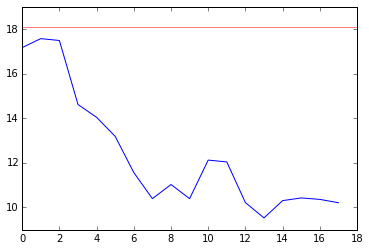

Name of Peptide Htr2c
Base Energy 5.87031674462
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 3.02221313267 Sequence ['R', 'I', 'S', 'S', 'I']



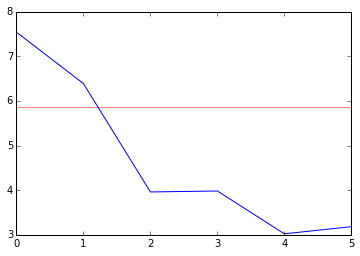

Name of Peptide JAM-1
Base Energy 6.36765080863
Base Sequence ['S', 'S', 'F', 'L', 'V']

 Cycle number : 1

Lowest Energy 1.16234744351 Sequence ['S', 'S', 'F', 'T', 'C']



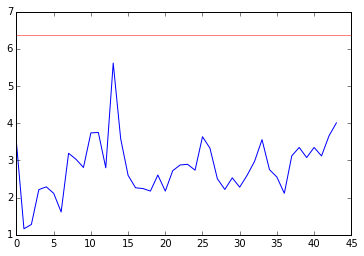

Name of Peptide KIF17
Base Energy 4.01838283588
Base Sequence ['G', 'G', 'E', 'P', 'L']

 Cycle number : 1

Lowest Energy 1.47906730907 Sequence ['R', 'Y', 'T', 'M', 'W']



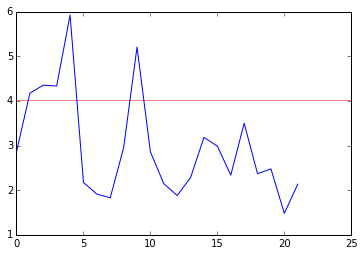

Name of Peptide KIF1B
Base Energy 26.4271991025
Base Sequence ['R', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 3.26412866837 Sequence ['R', 'E', 'P', 'T', 'V']



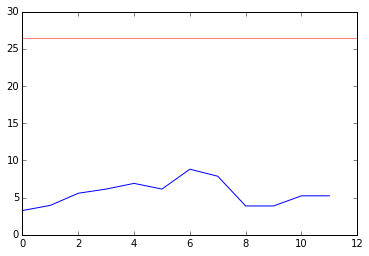

Name of Peptide Kir2.1
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 9.3159494446 Sequence ['R', 'H', 'R', 'A', 'I']



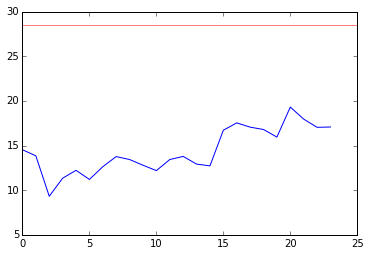

Name of Peptide Kv1.4
Base Energy 49.9055472783
Base Sequence ['V', 'E', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 22.829579424 Sequence ['G', 'E', 'T', 'N', 'T']



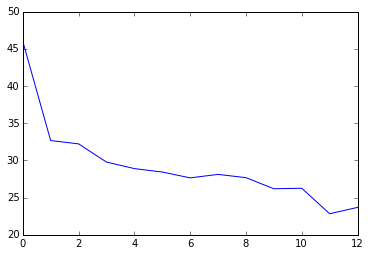

Name of Peptide Lgltminase
Base Energy 4.54834097666
Base Sequence ['L', 'E', 'S', 'M', 'V']

 Cycle number : 1

Lowest Energy 3.67328586634 Sequence ['L', 'E', 'S', 'M', 'G']



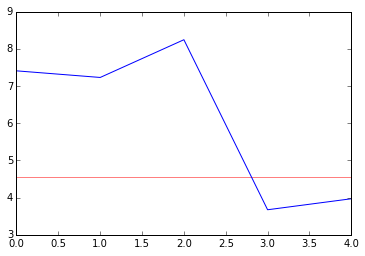

Name of Peptide Liprin2
Base Energy 7.84514190615
Base Sequence ['R', 'T', 'Y', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.11079615915 Sequence ['A', 'E', 'Q', 'G', 'P']



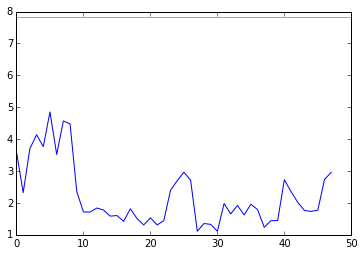

Name of Peptide Megalin
Base Energy 6.7113293881
Base Sequence ['E', 'D', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 3.24995024092 Sequence ['C', 'N', 'S', 'D', 'V']



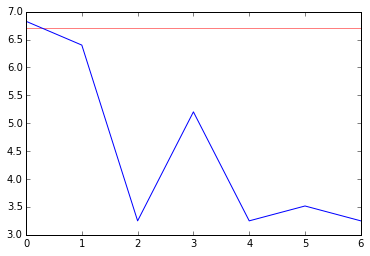

Name of Peptide Mel1a/b
Base Energy 17.76549867
Base Sequence ['K', 'V', 'D', 'S', 'V']

 Cycle number : 1

Lowest Energy 3.09321344681 Sequence ['K', 'V', 'P', 'S', 'P']



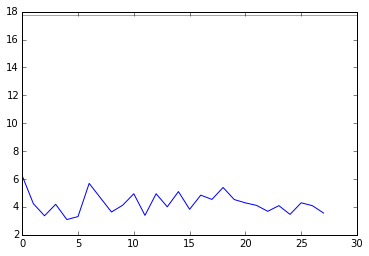

Name of Peptide mGluR3
Base Energy 10.059792039
Base Sequence ['T', 'T', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 5.72819107291 Sequence ['T', 'H', 'K', 'S', 'L']



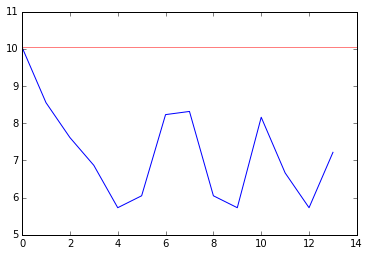

Name of Peptide ctransprtr
Base Energy 3.70916853858
Base Sequence ['N', 'A', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 3.70916853858 Sequence ['N', 'A', 'T', 'R', 'L']



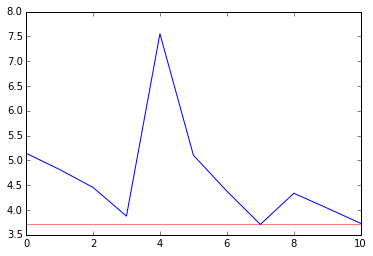

Name of Peptide Nav1.4
Base Energy 18.1065927851
Base Sequence ['K', 'E', 'S', 'L', 'V']

 Cycle number : 1

Lowest Energy 18.7396788178 Sequence ['K', 'E', 'S', 'L', 'I']



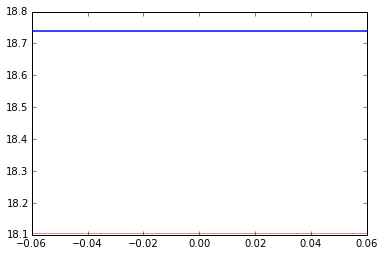

Name of Peptide Nav1.5
Base Energy 19.5874496371
Base Sequence ['R', 'E', 'S', 'I', 'V']

 Cycle number : 1

Lowest Energy 14.5994637771 Sequence ['L', 'E', 'S', 'C', 'V']



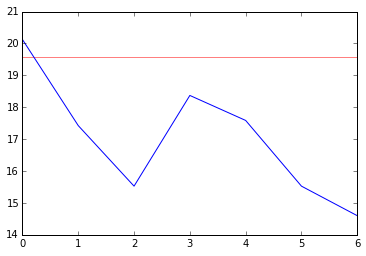

Name of Peptide Neurxin1/2
Base Energy 34.7545858124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 6.64397138651 Sequence ['A', 'E', 'Y', 'F', 'S']



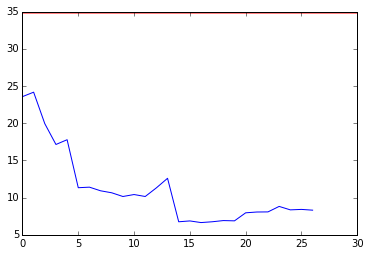

Name of Peptide NMDAR2A
Base Energy 24.0655913503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 5.44837796044 Sequence ['C', 'E', 'S', 'D', 'V']



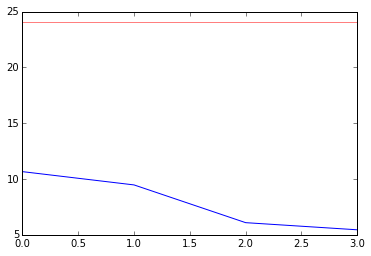

Name of Peptide NMDAR2B
Base Energy 17.5025963503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 10.6208592943 Sequence ['L', 'E', 'P', 'D', 'I']



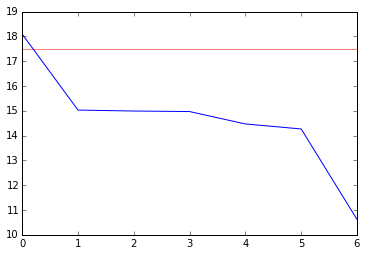

Name of Peptide P2Y1
Base Energy 28.625230555
Base Sequence ['G', 'D', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 12.3368677092 Sequence ['C', 'D', 'T', 'S', 'M']



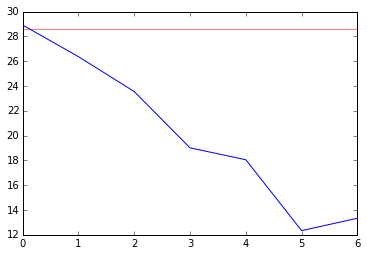

Name of Peptide Parkin
Base Energy 2.06541536473
Base Sequence ['H', 'W', 'F', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.87690864226 Sequence ['L', 'W', 'M', 'D', 'G']



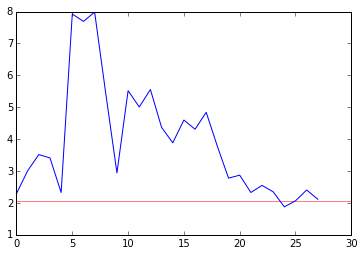

Name of Peptide PDGFR
Base Energy 14.6647382588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 1.48775272636 Sequence ['G', 'D', 'G', 'N', 'D']



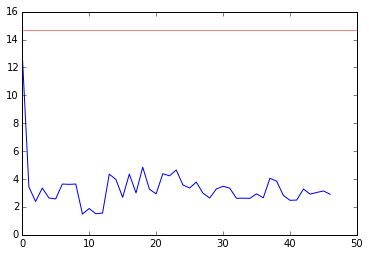

Name of Peptide PFK-M
Base Energy 15.2354145009
Base Sequence ['G', 'E', 'A', 'A', 'V']

 Cycle number : 1

Lowest Energy 1.01675024909 Sequence ['K', 'E', 'K', 'N', 'H']



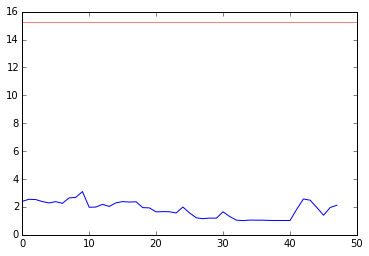

Name of Peptide PIX
Base Energy 27.0731044414
Base Sequence ['D', 'E', 'T', 'N', 'L']

 Cycle number : 1

Lowest Energy 18.3121330855 Sequence ['D', 'E', 'Q', 'N', 'L']



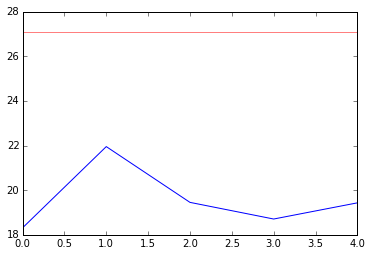

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 4.08183724405 Sequence ['I', 'Q', 'S', 'A', 'G']



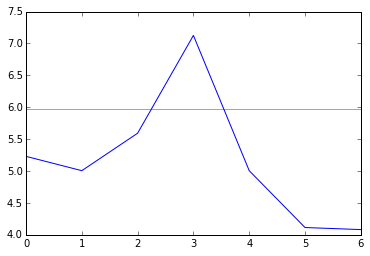

Name of Peptide PMCA1
Base Energy 30.2193108669
Base Sequence ['L', 'E', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 16.7542574086 Sequence ['A', 'E', 'T', 'S', 'L']



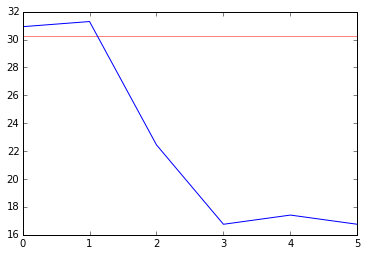

Name of Peptide Ril
Base Energy 31.9187527305
Base Sequence ['K', 'V', 'E', 'L', 'V']

 Cycle number : 1

Lowest Energy 13.7337650704 Sequence ['A', 'I', 'P', 'G', 'A']



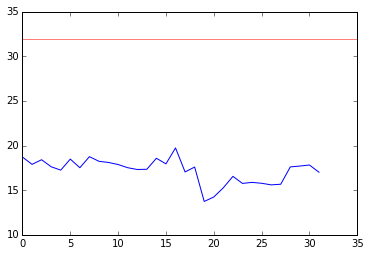

Name of Peptide Sapk3
Base Energy 25.7589244175
Base Sequence ['K', 'E', 'T', 'A', 'L']

 Cycle number : 1

Lowest Energy 13.1699371859 Sequence ['E', 'E', 'T', 'A', 'G']



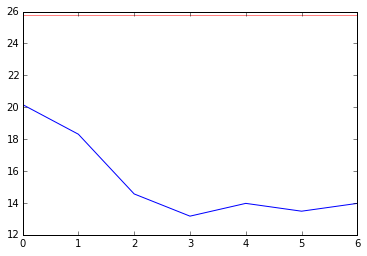

Name of Peptide SSTR2
Base Energy 8.04013252582
Base Sequence ['I', 'I', 'A', 'W', 'V']

 Cycle number : 1

Lowest Energy 8.15216327614 Sequence ['L', 'I', 'A', 'W', 'V']



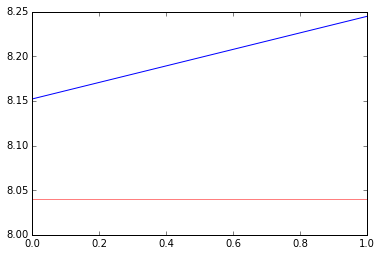

Name of Peptide Stargazin
Base Energy 19.2404872197
Base Sequence ['R', 'T', 'T', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.05199860091 Sequence ['R', 'T', 'C', 'P', 'G']



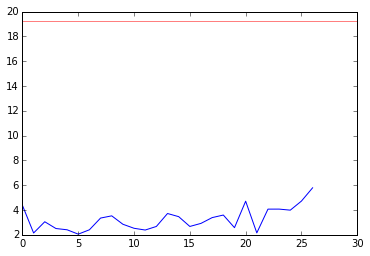

Name of Peptide Syndecan1
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 2.29514650724 Sequence ['E', 'E', 'R', 'W', 'A']



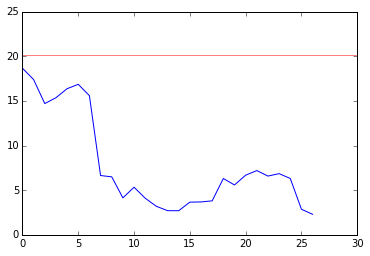

Name of Peptide Syndecan2
Base Energy 36.8856289754
Base Sequence ['K', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 3.01651793025 Sequence ['P', 'H', 'C', 'M', 'A']



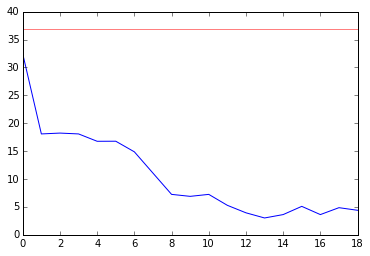

Name of Peptide TAZ
Base Energy 17.1937505167
Base Sequence ['F', 'L', 'T', 'W', 'L']

 Cycle number : 1

Lowest Energy 7.62776434469 Sequence ['F', 'P', 'T', 'W', 'L']



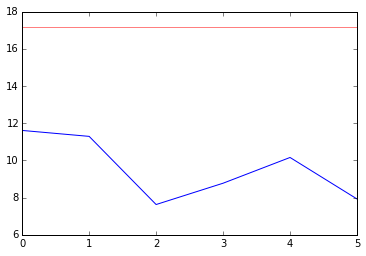

Name of Peptide Trip6
Base Energy 21.3116037858
Base Sequence ['V', 'T', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 0.942824665536 Sequence ['A', 'E', 'K', 'C', 'V']



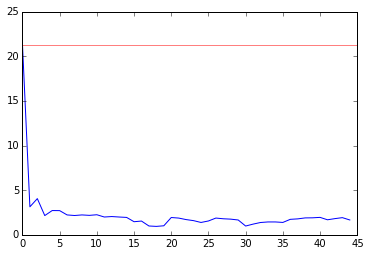

Name of Peptide TRPC4
Base Energy 3.49309391044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 1.68768003119 Sequence ['V', 'H', 'T', 'R', 'A']



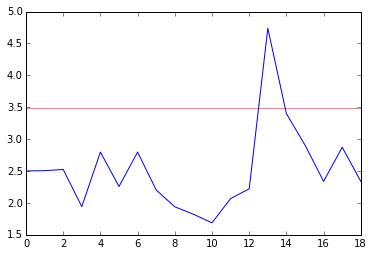

Name of Peptide AcvR1
Base Energy 8.1782910361
Base Sequence ['L', 'K', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 1.84225895813 Sequence ['A', 'K', 'T', 'D', 'S']



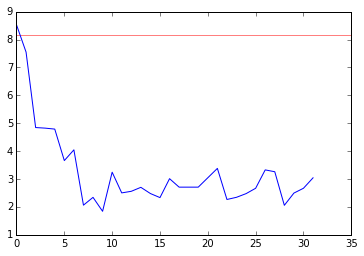

Name of Peptide AcvR2
Base Energy 28.2894100244
Base Sequence ['K', 'E', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 13.4591079654 Sequence ['E', 'E', 'S', 'S', 'L']



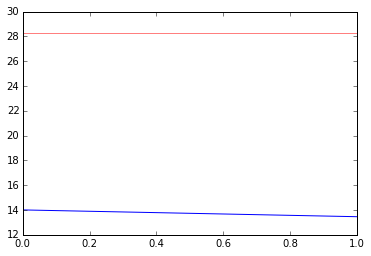

Name of Peptide AcvR2b
Base Energy 36.0467473257
Base Sequence ['K', 'E', 'S', 'S', 'I']

 Cycle number : 1

Lowest Energy 9.81822668148 Sequence ['H', 'E', 'P', 'S', 'I']



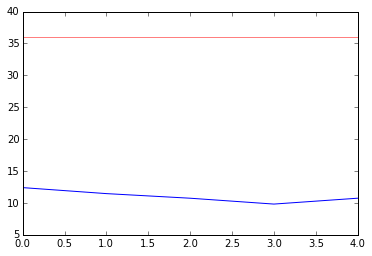

Name of Peptide Cacna1a
Base Energy 17.1905846257
Base Sequence ['E', 'D', 'D', 'W', 'C']

 Cycle number : 1

Lowest Energy 2.22574471348 Sequence ['A', 'E', 'S', 'W', 'T']



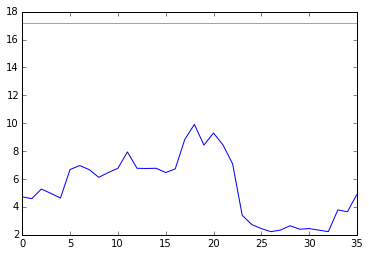

Name of Peptide Cav1.2
Base Energy 54.0718184806
Base Sequence ['Y', 'V', 'S', 'N', 'L']

 Cycle number : 1

Lowest Energy 6.0570282568 Sequence ['E', 'T', 'S', 'N', 'L']



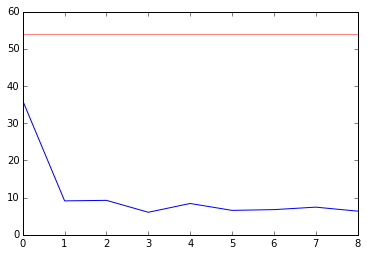

Name of Peptide Cav2.3
Base Energy 4.74582296906
Base Sequence ['E', 'D', 'D', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.24951529368 Sequence ['P', 'H', 'E', 'A', 'M']



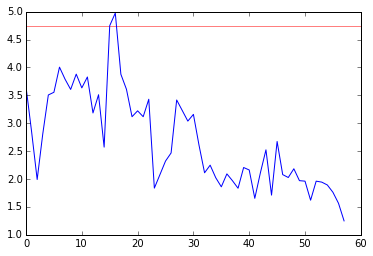

Name of Peptide Cav3.2
Base Energy 2.13818288188
Base Sequence ['G', 'D', 'E', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.43759899688 Sequence ['P', 'N', 'Q', 'C', 'I']



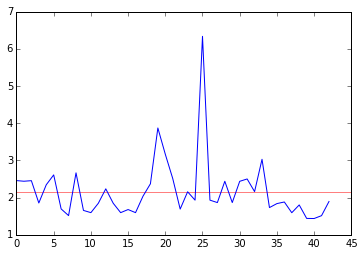

Name of Peptide ITPR3
Base Energy 3.90395331342
Base Sequence ['N', 'C', 'M', 'S', 'R']

 Cycle number : 1

Lowest Energy 1.45799570995 Sequence ['R', 'P', 'M', 'A', 'A']



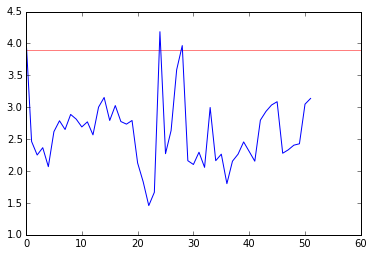

Name of Peptide RYR2
Base Energy 4.81261114343
Base Sequence ['E', 'D', 'Q', 'L', 'N']

 Cycle number : 1

Lowest Energy 1.23763549087 Sequence ['K', 'D', 'R', 'E', 'M']



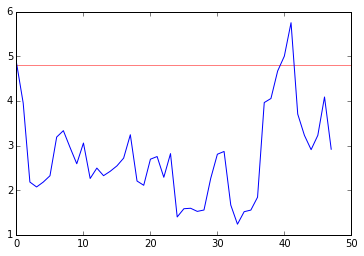

Name of Peptide SERCA1
Base Energy 13.7805269613
Base Sequence ['N', 'Y', 'L', 'E', 'G']

 Cycle number : 1

Lowest Energy 1.17076464722 Sequence ['P', 'E', 'N', 'N', 'Q']



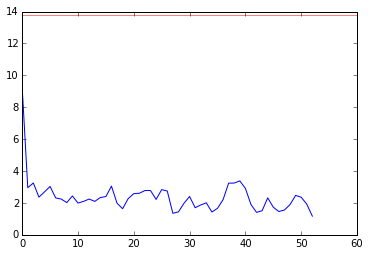

Name of Peptide SERCA2A
Base Energy 5.04661264325
Base Sequence ['P', 'A', 'I', 'L', 'E']

 Cycle number : 1

Lowest Energy 1.47268716974 Sequence ['K', 'A', 'G', 'N', 'H']



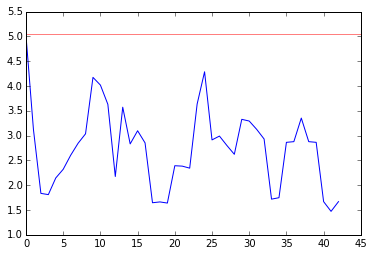

Name of Peptide SERCA3
Base Energy 6.2704518053
Base Sequence ['V', 'W', 'P', 'S', 'D']

 Cycle number : 1

Lowest Energy 1.74705272008 Sequence ['W', 'Q', 'P', 'V', 'S']



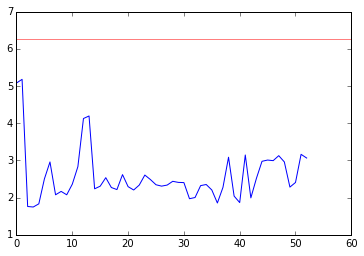

Name of Peptide TPC1
Base Energy 8.92322025265
Base Sequence ['S', 'Q', 'T', 'V', 'T']

 Cycle number : 1

Lowest Energy 0.917723130911 Sequence ['K', 'D', 'C', 'D', 'K']



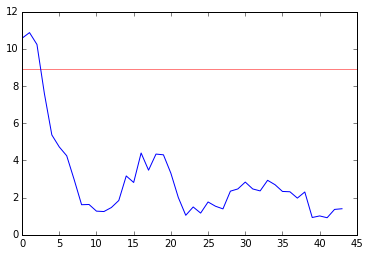

Name of Peptide Claudin2
Base Energy 11.3170000173
Base Sequence ['L', 'T', 'G', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.95800394343 Sequence ['P', 'P', 'R', 'Y', 'L']



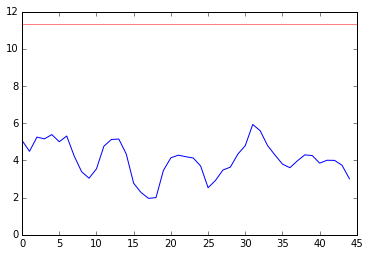

Name of Peptide Claudin3
Base Energy 7.17366012465
Base Sequence ['R', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.28761837197 Sequence ['L', 'K', 'N', 'W', 'P']



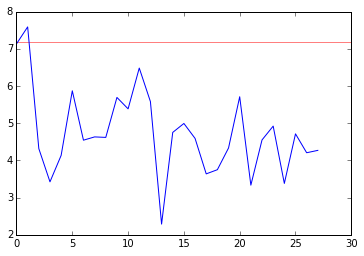

Name of Peptide Claudin4
Base Energy 9.66498096644
Base Sequence ['A', 'S', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.98835413515 Sequence ['C', 'H', 'N', 'G', 'V']



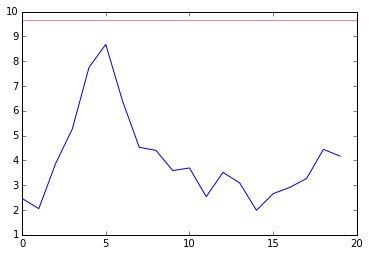

Name of Peptide Claudin5
Base Energy 69.1904204791
Base Sequence ['K', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.57629069148 Sequence ['I', 'K', 'C', 'E', 'A']



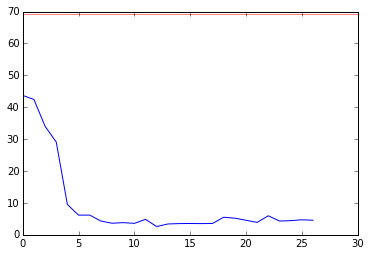

Name of Peptide Claudin6
Base Energy 52.2853897426
Base Sequence ['T', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.59381956974 Sequence ['I', 'H', 'N', 'G', 'P']



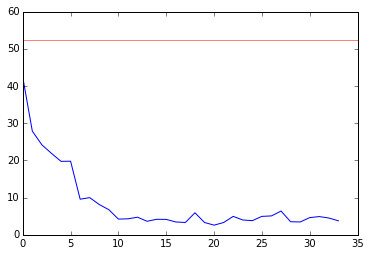

Name of Peptide Claudin7
Base Energy 14.8914186154
Base Sequence ['S', 'K', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.53237671413 Sequence ['V', 'Q', 'P', 'Y', 'Q']



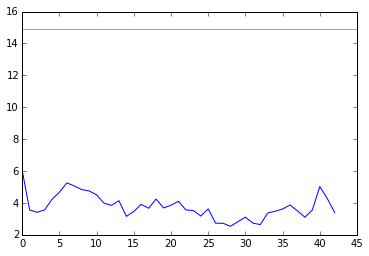

Name of Peptide Claudin8
Base Energy 7.60195464094
Base Sequence ['K', 'S', 'Q', 'Y', 'V']

 Cycle number : 1

Lowest Energy 5.88718870179 Sequence ['H', 'P', 'Q', 'Y', 'G']



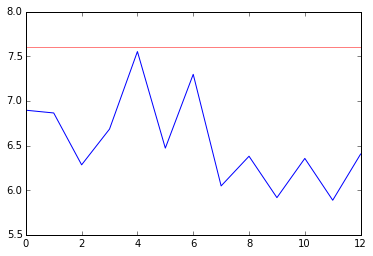

Name of Peptide Claudin9
Base Energy 13.0920258928
Base Sequence ['K', 'R', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 0.997420688284 Sequence ['K', 'E', 'A', 'M', 'T']



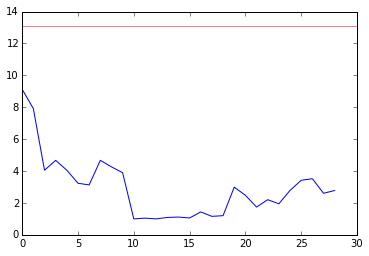

Name of Peptide Claudin10
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.35474669011 Sequence ['K', 'N', 'A', 'D', 'P']



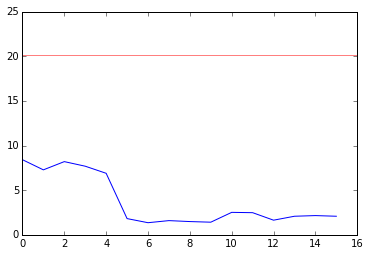

Name of Peptide Claudin11
Base Energy 19.3286831196
Base Sequence ['K', 'S', 'A', 'H', 'V']

 Cycle number : 1

Lowest Energy 1.94573218251 Sequence ['K', 'M', 'A', 'H', 'R']



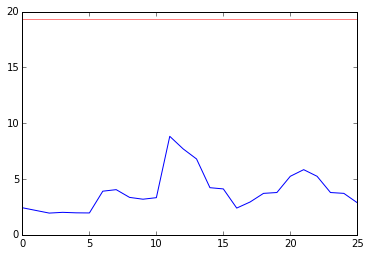

Name of Peptide Claudin13
Base Energy 5.36008828371
Base Sequence ['D', 'T', 'L', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.41450066335 Sequence ['K', 'D', 'C', 'E', 'R']



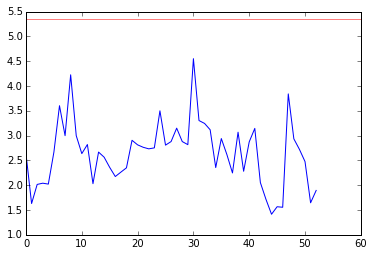

Name of Peptide Claudin14
Base Energy 1.69869817987
Base Sequence ['L', 'N', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.69869817987 Sequence ['L', 'N', 'D', 'Y', 'V']



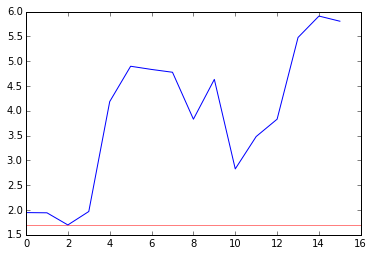

Name of Peptide Claudin15
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.56557192483 Sequence ['K', 'H', 'A', 'G', 'M']



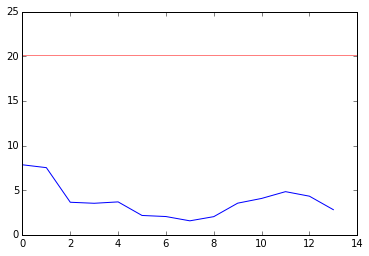

Name of Peptide Claudin16
Base Energy 33.1307825301
Base Sequence ['V', 'D', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 8.29762365396 Sequence ['A', 'H', 'T', 'E', 'V']



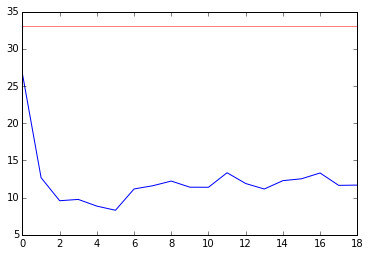

Name of Peptide Claudin18
Base Energy 29.3482977089
Base Sequence ['K', 'Y', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.89103578831 Sequence ['I', 'C', 'P', 'Y', 'M']



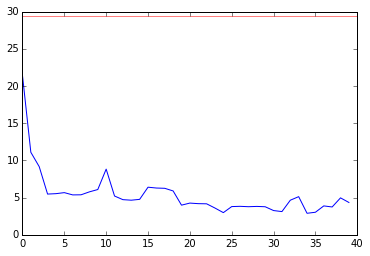

Name of Peptide Claudin19
Base Energy 4.89381545106
Base Sequence ['A', 'R', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.17266393151 Sequence ['H', 'R', 'Q', 'D', 'G']



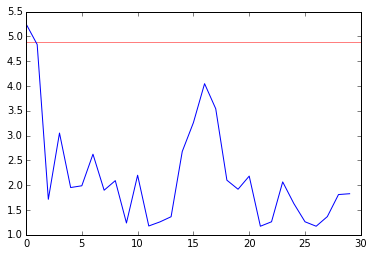

Name of Peptide Claudin22
Base Energy 2.30310124649
Base Sequence ['A', 'N', 'P', 'E', 'I']

 Cycle number : 1

Lowest Energy 1.18514975558 Sequence ['H', 'Q', 'Q', 'D', 'E']



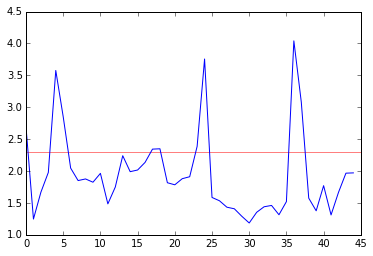

Name of Peptide Claudin23
Base Energy 2.47978086236
Base Sequence ['C', 'D', 'S', 'D', 'L']

 Cycle number : 1

Lowest Energy 1.85986760837 Sequence ['C', 'D', 'E', 'D', 'I']



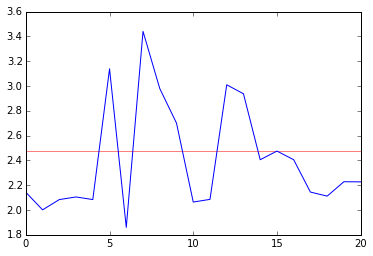

Name of Peptide EphrinB3
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.09350288733 Sequence ['H', 'E', 'H', 'K', 'C']



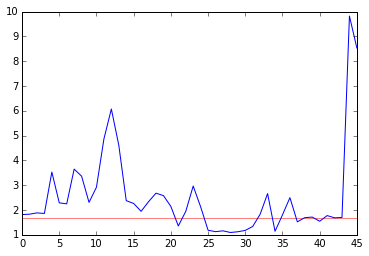

Name of Peptide GluR2_2
Base Energy 8.59842602681
Base Sequence ['V', 'T', 'D', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.6420039122 Sequence ['A', 'E', 'L', 'G', 'I']



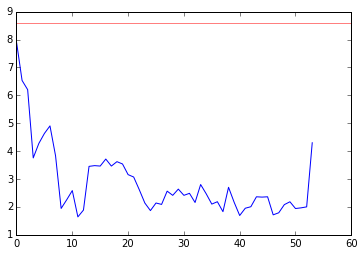

Name of Peptide GluR2_3
Base Energy 6.26261640287
Base Sequence ['L', 'G', 'W', 'V', 'E']

 Cycle number : 1

Lowest Energy 1.20710655697 Sequence ['K', 'A', 'P', 'A', 'W']



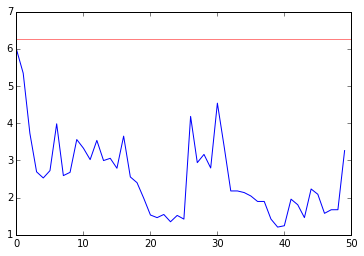

Name of Peptide GluR3
Base Energy 20.4335030733
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.63016002033 Sequence ['Q', 'A', 'N', 'D', 'Y']



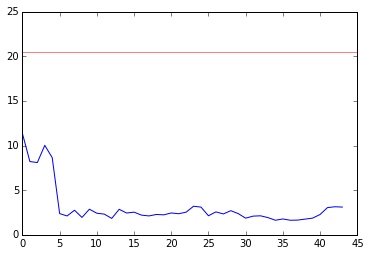

Name of Peptide GluR5_2
Base Energy 31.6788017701
Base Sequence ['S', 'V', 'H', 'T', 'V']

 Cycle number : 1

Lowest Energy 1.88111259224 Sequence ['V', 'D', 'F', 'A', 'A']



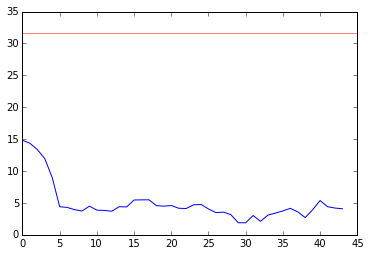

Name of Peptide GluRdelta1
Base Energy 30.759492334
Base Sequence ['H', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 9.61536469067 Sequence ['N', 'Q', 'K', 'S', 'I']



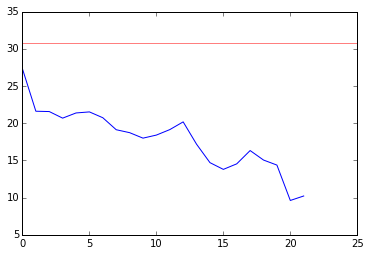

Name of Peptide GluRdelta2
Base Energy 23.7971790916
Base Sequence ['R', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 7.07420501021 Sequence ['R', 'Q', 'K', 'S', 'L']



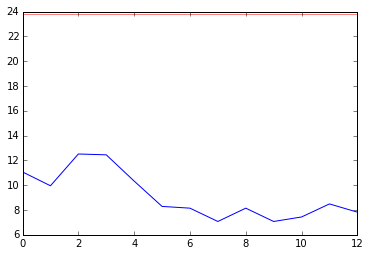

Name of Peptide KA-2
Base Energy 12.6744224267
Base Sequence ['L', 'T', 'E', 'H', 'E']

 Cycle number : 1

Lowest Energy 1.03251129023 Sequence ['R', 'P', 'G', 'D', 'P']



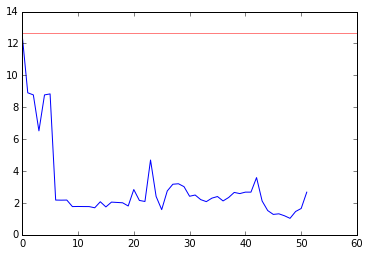

Name of Peptide mGluR1
Base Energy 15.8797011742
Base Sequence ['S', 'S', 'S', 'T', 'L']

 Cycle number : 1

Lowest Energy 3.74865699967 Sequence ['D', 'E', 'N', 'K', 'L']



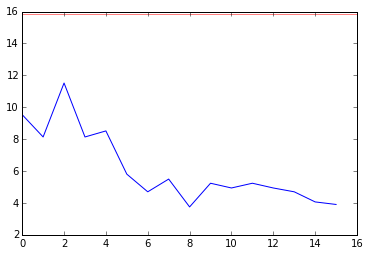

Name of Peptide NMDAR1
Base Energy 1.99695789843
Base Sequence ['R', 'H', 'R', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.37197004941 Sequence ['R', 'H', 'G', 'E', 'W']



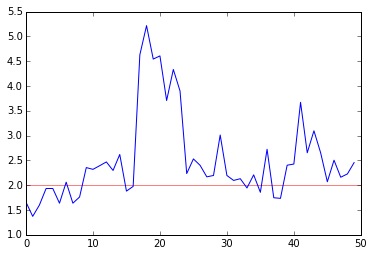

Name of Peptide NMDAR2C
Base Energy 29.899606913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 8.29193824493 Sequence ['L', 'E', 'S', 'S', 'S']



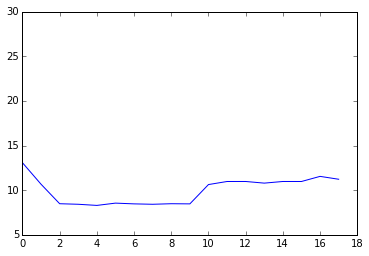

Name of Peptide NMDAR2D
Base Energy 22.839446913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 9.29243388444 Sequence ['P', 'E', 'S', 'E', 'G']



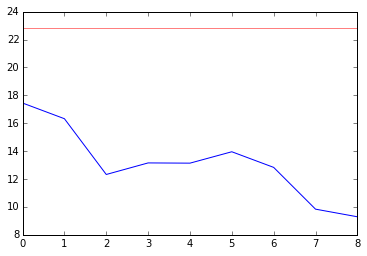

Name of Peptide NMDAR3B
Base Energy 3.36347448554
Base Sequence ['A', 'P', 'A', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.51444410382 Sequence ['G', 'P', 'K', 'N', 'V']



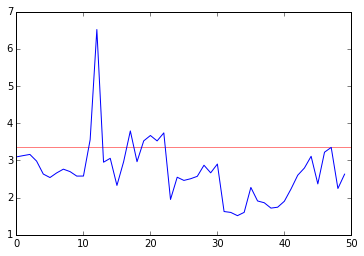

Name of Peptide Nuroligin1
Base Energy 12.2288089523
Base Sequence ['Y', 'K', 'R', 'C', 'E']

 Cycle number : 1

Lowest Energy 1.06887763294 Sequence ['P', 'E', 'G', 'P', 'Y']



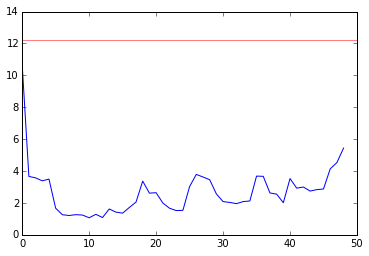

Name of Peptide Nuroligin2
Base Energy 17.9974531125
Base Sequence ['S', 'T', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 1.95996378541 Sequence ['A', 'E', 'C', 'R', 'A']



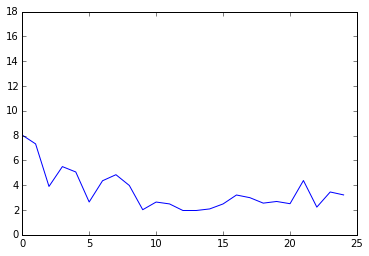

Name of Peptide Nuroligin3
Base Energy 5.32349049893
Base Sequence ['P', 'T', 'D', 'L', 'F']

 Cycle number : 1

Lowest Energy 1.9223060591 Sequence ['S', 'P', 'N', 'A', 'T']



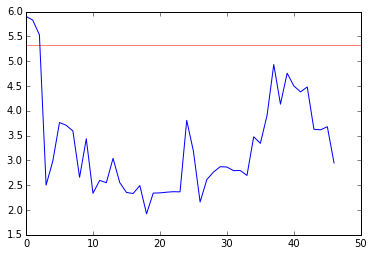

Name of Peptide Caspr4
Base Energy 30.6896720937
Base Sequence ['K', 'E', 'Y', 'F', 'F']

 Cycle number : 1

Lowest Energy 9.27862402508 Sequence ['W', 'P', 'M', 'F', 'F']



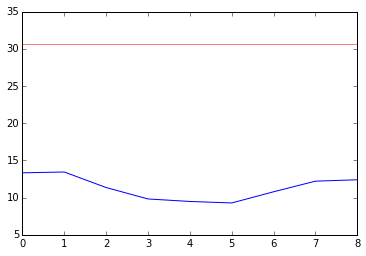

Name of Peptide Neurexin3
Base Energy 58.8228348124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 6.77736477589 Sequence ['G', 'E', 'I', 'F', 'C']



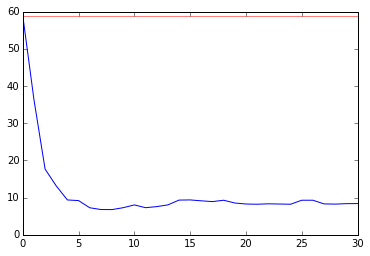

Name of Peptide Neurexin4
Base Energy 4.01358055511
Base Sequence ['E', 'S', 'R', 'S', 'E']

 Cycle number : 1

Lowest Energy 0.980726159062 Sequence ['K', 'P', 'R', 'D', 'L']



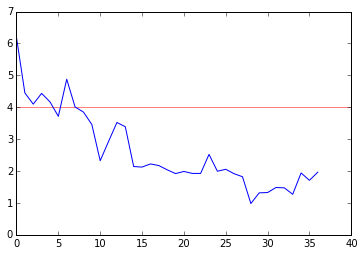

Name of Peptide CNGA2
Base Energy 2.40743083986
Base Sequence ['P', 'A', 'V', 'A', 'E']

 Cycle number : 1

Lowest Energy 1.43027786375 Sequence ['K', 'A', 'Q', 'A', 'D']



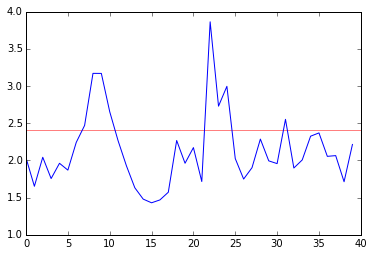

Name of Peptide CNGA3
Base Energy 4.35629541192
Base Sequence ['A', 'S', 'K', 'T', 'D']

 Cycle number : 1

Lowest Energy 1.17094957994 Sequence ['R', 'D', 'V', 'N', 'M']



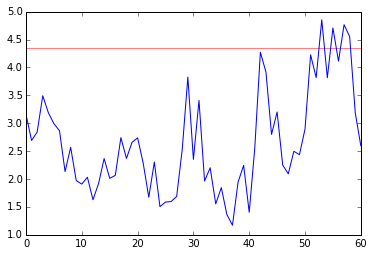

Name of Peptide KCNAB2
Base Energy 18.0435733761
Base Sequence ['K', 'D', 'Y', 'R', 'S']

 Cycle number : 1

Lowest Energy 1.20305315028 Sequence ['K', 'D', 'G', 'C', 'Y']



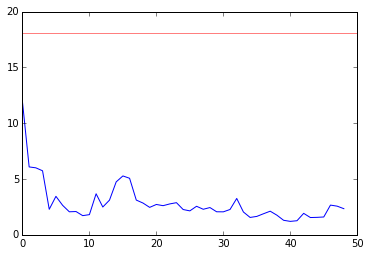

Name of Peptide KCNE1
Base Energy 9.2223302792
Base Sequence ['L', 'K', 'P', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.96626908194 Sequence ['N', 'P', 'K', 'D', 'V']



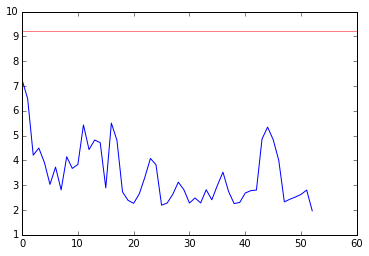

Name of Peptide KCNE4_1
Base Energy 15.9009957792
Base Sequence ['L', 'V', 'S', 'I', 'C']

 Cycle number : 1

Lowest Energy 6.00334543038 Sequence ['N', 'V', 'S', 'V', 'C']



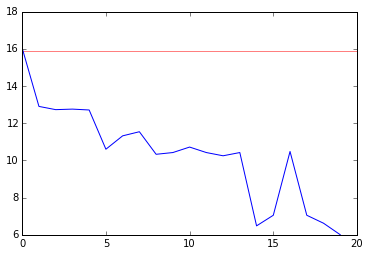

Name of Peptide KCNE4_2
Base Energy 2.06595170156
Base Sequence ['I', 'H', 'Q', 'N', 'S']

 Cycle number : 1

Lowest Energy 1.05526983531 Sequence ['K', 'A', 'P', 'D', 'W']



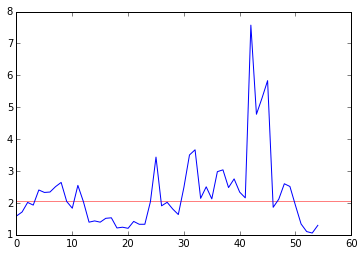

Name of Peptide KCNH1
Base Energy 6.18186639765
Base Sequence ['I', 'F', 'G', 'A', 'S']

 Cycle number : 1

Lowest Energy 1.19515928276 Sequence ['R', 'G', 'V', 'D', 'P']



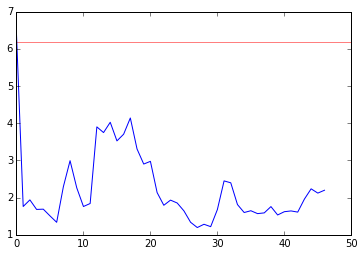

Name of Peptide KCNK3
Base Energy 49.5586585855
Base Sequence ['R', 'R', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.43770035041 Sequence ['G', 'H', 'Q', 'T', 'C']



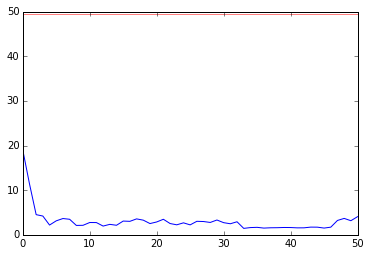

Name of Peptide KCNK4_1
Base Energy 11.3226351038
Base Sequence ['K', 'A', 'M', 'A', 'I']

 Cycle number : 1

Lowest Energy 1.0915052231 Sequence ['H', 'H', 'A', 'D', 'W']



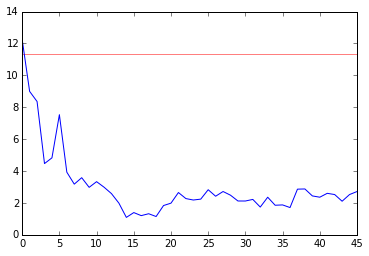

Name of Peptide KCNK4_2
Base Energy 7.31694597677
Base Sequence ['K', 'A', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 0.977983945431 Sequence ['H', 'E', 'P', 'N', 'A']



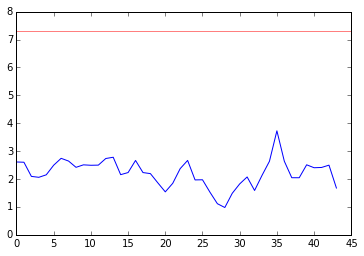

Name of Peptide KCNK5
Base Energy 3.13513099391
Base Sequence ['N', 'P', 'R', 'G', 'T']

 Cycle number : 1

Lowest Energy 1.28743106187 Sequence ['W', 'E', 'K', 'G', 'C']



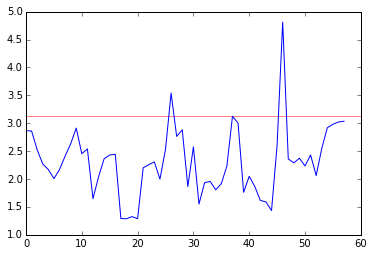

Name of Peptide KCNK6
Base Energy 2.84641615851
Base Sequence ['A', 'P', 'R', 'S', 'A']

 Cycle number : 1

Lowest Energy 0.808294788143 Sequence ['K', 'G', 'K', 'D', 'P']



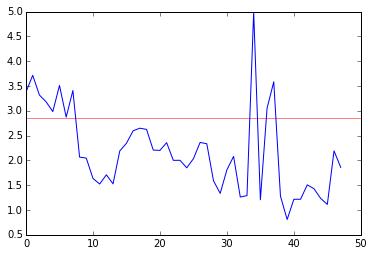

Name of Peptide KCNK7
Base Energy 8.87759422891
Base Sequence ['P', 'T', 'T', 'P', 'A']

 Cycle number : 1

Lowest Energy 1.17070813951 Sequence ['G', 'E', 'G', 'C', 'W']



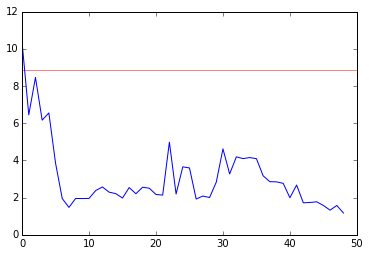

Name of Peptide KCNQ2
Base Energy 11.7892273577
Base Sequence ['V', 'T', 'S', 'Q', 'L']

 Cycle number : 1

Lowest Energy 1.20712294941 Sequence ['G', 'E', 'Q', 'C', 'P']



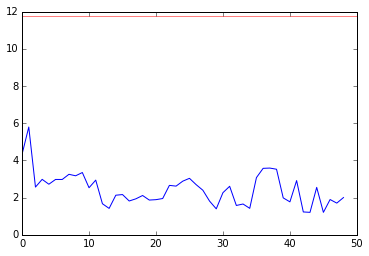

Name of Peptide KCNQ3
Base Energy 3.51115603645
Base Sequence ['S', 'N', 'K', 'P', 'T']

 Cycle number : 1

Lowest Energy 1.19770910479 Sequence ['R', 'H', 'G', 'D', 'H']



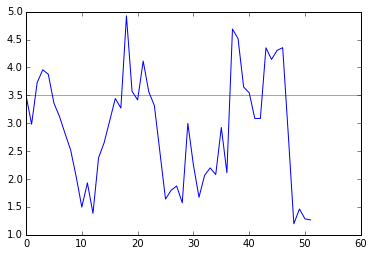

Name of Peptide Kir2.2
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 3.11501531143 Sequence ['G', 'Q', 'N', 'A', 'R']



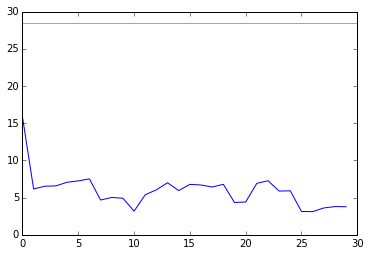

Name of Peptide Kir3.1
Base Energy 12.2859982745
Base Sequence ['S', 'D', 'R', 'F', 'T']

 Cycle number : 1

Lowest Energy 1.30685401734 Sequence ['G', 'E', 'E', 'G', 'D']



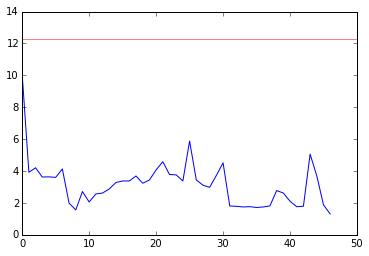

Name of Peptide Kir3.2_1
Base Energy 4.26660335563
Base Sequence ['A', 'T', 'G', 'Q', 'F']

 Cycle number : 1

Lowest Energy 1.4219877456 Sequence ['K', 'T', 'G', 'D', 'K']



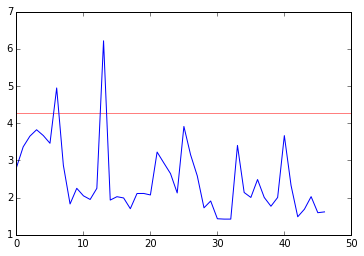

Name of Peptide Kir3.2_2
Base Energy 13.9810575588
Base Sequence ['N', 'E', 'S', 'K', 'V']

 Cycle number : 1

Lowest Energy 3.35393391247 Sequence ['N', 'E', 'S', 'E', 'T']



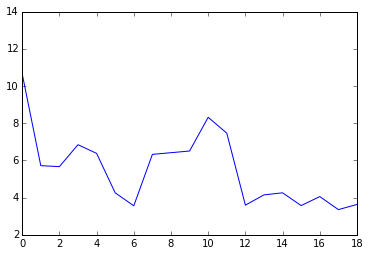

Name of Peptide Kir3.2_3
Base Energy 1.69536422253
Base Sequence ['T', 'E', 'R', 'N', 'G']

 Cycle number : 1

Lowest Energy 1.06540442788 Sequence ['R', 'C', 'P', 'D', 'M']



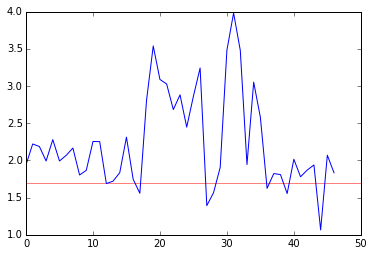

Name of Peptide Kir3.3
Base Energy 19.5663537291
Base Sequence ['S', 'E', 'S', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.02217585915 Sequence ['P', 'H', 'S', 'T', 'W']



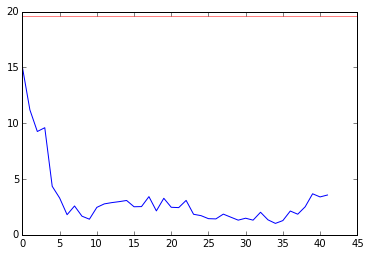

Name of Peptide Kir3.4
Base Energy 13.4005530879
Base Sequence ['T', 'R', 'G', 'S', 'M']

 Cycle number : 1

Lowest Energy 1.4691617388 Sequence ['P', 'H', 'Q', 'E', 'V']



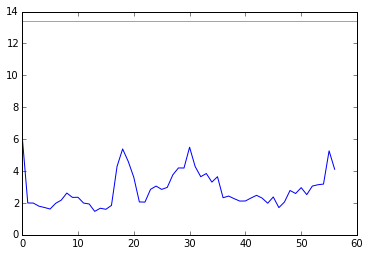

Name of Peptide Kir4.1
Base Energy 8.40031322706
Base Sequence ['R', 'I', 'S', 'N', 'V']

 Cycle number : 1

Lowest Energy 5.61375794693 Sequence ['R', 'V', 'S', 'N', 'M']



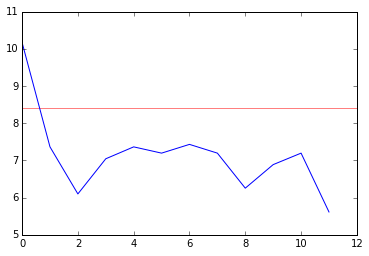

Name of Peptide Kir4.2
Base Energy 16.8040004786
Base Sequence ['Q', 'Q', 'S', 'N', 'V']

 Cycle number : 1

Lowest Energy 3.81533098107 Sequence ['Q', 'D', 'S', 'G', 'V']



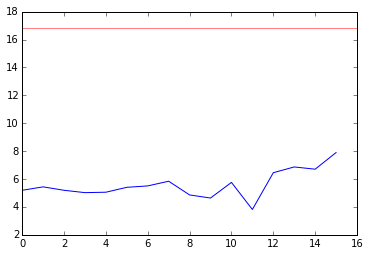

Name of Peptide Kir5.1
Base Energy 34.2847075124
Base Sequence ['M', 'E', 'S', 'Q', 'M']

 Cycle number : 1

Lowest Energy 1.60313825771 Sequence ['P', 'A', 'S', 'G', 'F']



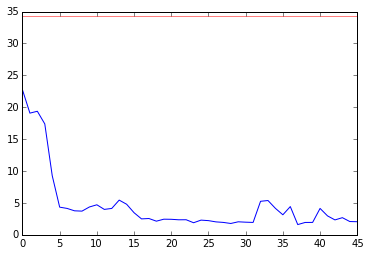

Name of Peptide Kir6.1
Base Energy 3.60183439172
Base Sequence ['C', 'P', 'S', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.49717529845 Sequence ['W', 'Q', 'C', 'D', 'N']



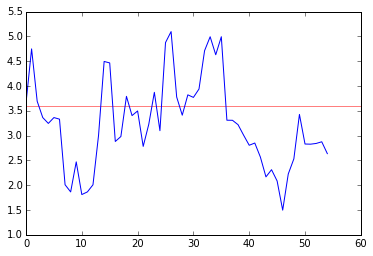

Name of Peptide Kir6.2
Base Energy 6.25762005234
Base Sequence ['P', 'D', 'S', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.24020508644 Sequence ['H', 'E', 'Q', 'G', 'W']



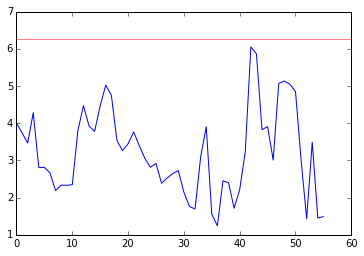

Name of Peptide Kv1.1
Base Energy 65.5208452336
Base Sequence ['L', 'L', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 2.08063233308 Sequence ['K', 'P', 'S', 'D', 'L']



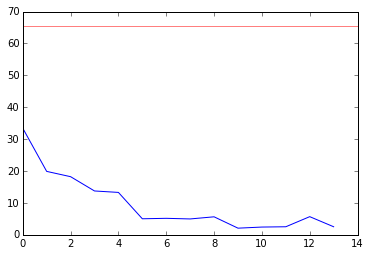

Name of Peptide Kv1.2
Base Energy 104.671429206
Base Sequence ['M', 'L', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.04168467548 Sequence ['H', 'E', 'E', 'S', 'W']



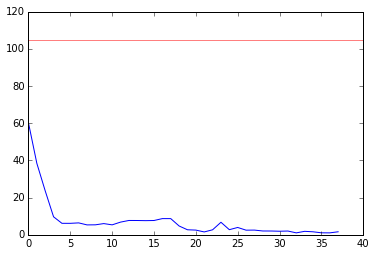

Name of Peptide Kv1.3
Base Energy 24.7435125126
Base Sequence ['I', 'F', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 7.0300729431 Sequence ['I', 'F', 'T', 'D', 'R']



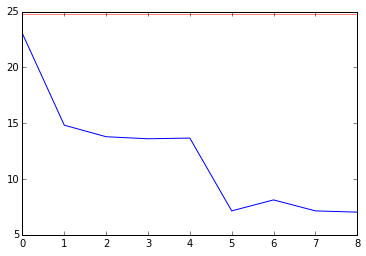

Name of Peptide Kv1.5
Base Energy 68.8594422475
Base Sequence ['R', 'E', 'T', 'D', 'L']

 Cycle number : 1

Lowest Energy 9.7774027208 Sequence ['R', 'E', 'K', 'D', 'L']



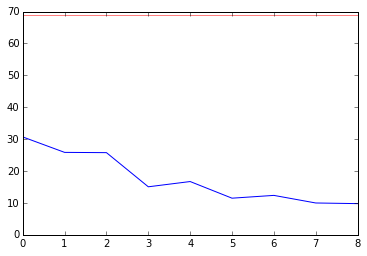

Name of Peptide Kv1.6
Base Energy 84.7184117939
Base Sequence ['M', 'L', 'T', 'E', 'V']

 Cycle number : 1

Lowest Energy 14.6837708962 Sequence ['E', 'L', 'E', 'G', 'T']



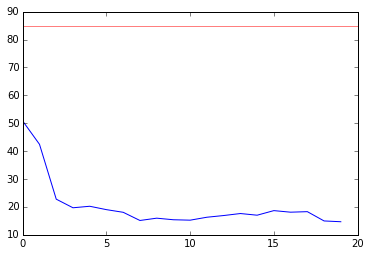

Name of Peptide Kv1.7
Base Energy 9.69282989865
Base Sequence ['M', 'V', 'T', 'E', 'V']

 Cycle number : 1

Lowest Energy 10.8592327152 Sequence ['M', 'V', 'T', 'I', 'G']



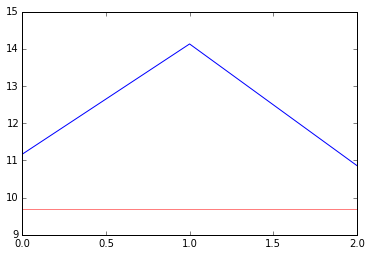

Name of Peptide Kv2.1
Base Energy 1.32396971665
Base Sequence ['R', 'D', 'Q', 'S', 'I']

 Cycle number : 1

Lowest Energy 1.09933570475 Sequence ['K', 'D', 'Q', 'S', 'P']



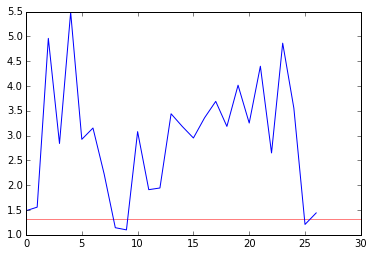

Name of Peptide Kv3.1
Base Energy 2.1503025057
Base Sequence ['R', 'G', 'M', 'S', 'I']

 Cycle number : 1

Lowest Energy 1.1854575906 Sequence ['V', 'E', 'N', 'S', 'F']



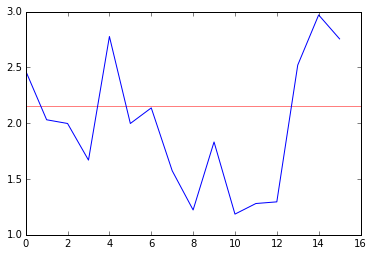

Name of Peptide Kv3.3_1
Base Energy 9.87045522656
Base Sequence ['L', 'P', 'S', 'I', 'L']

 Cycle number : 1

Lowest Energy 1.80600796265 Sequence ['G', 'P', 'A', 'G', 'P']



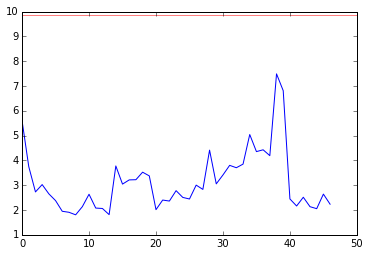

Name of Peptide Kv3.3_2
Base Energy 31.0460163321
Base Sequence ['S', 'E', 'T', 'Q', 'V']

 Cycle number : 1

Lowest Energy 17.4497147621 Sequence ['S', 'E', 'T', 'Q', 'D']



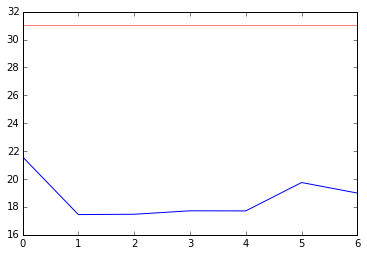

Name of Peptide Kv4.1
Base Energy 13.5896281787
Base Sequence ['K', 'I', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 3.78605611949 Sequence ['K', 'L', 'H', 'N', 'S']



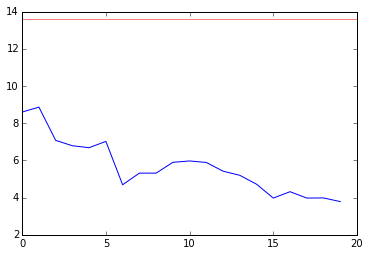

Name of Peptide Kv4.2
Base Energy 33.0314598618
Base Sequence ['R', 'V', 'S', 'A', 'L']

 Cycle number : 1

Lowest Energy 11.3427472433 Sequence ['R', 'D', 'E', 'S', 'L']



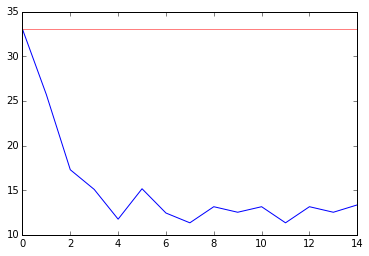

Name of Peptide Kv6.3
Base Energy 4.45383189455
Base Sequence ['A', 'E', 'F', 'L', 'N']

 Cycle number : 1

Lowest Energy 1.04932203024 Sequence ['A', 'E', 'G', 'P', 'V']



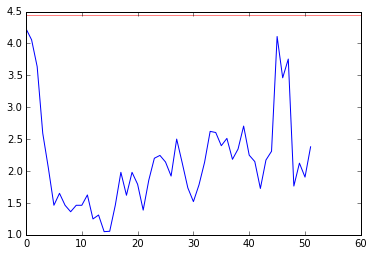

Name of Peptide Kv8.1
Base Energy 27.5027839935
Base Sequence ['D', 'D', 'F', 'W', 'F']

 Cycle number : 1

Lowest Energy 1.53575796075 Sequence ['C', 'E', 'V', 'P', 'E']



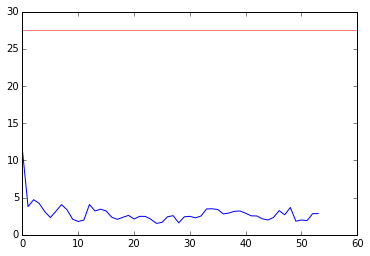

Name of Peptide Kv9.1
Base Energy 3.97213592363
Base Sequence ['K', 'S', 'H', 'S', 'Y']

 Cycle number : 1

Lowest Energy 1.23997992444 Sequence ['R', 'C', 'R', 'D', 'A']



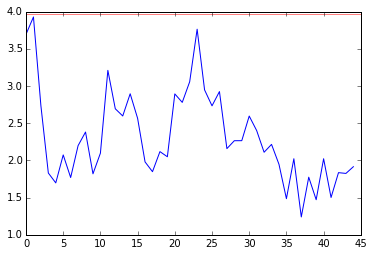

Name of Peptide KVLQT1
Base Energy 1.67987927109
Base Sequence ['P', 'D', 'E', 'G', 'S']

 Cycle number : 1

Lowest Energy 1.02063279172 Sequence ['A', 'E', 'A', 'P', 'Y']



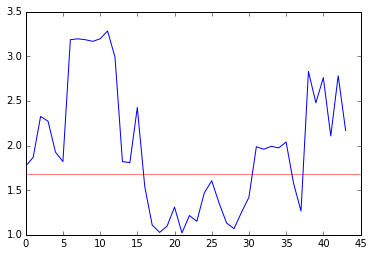

Name of Peptide AXL
Base Energy 4.69386807794
Base Sequence ['Q', 'E', 'D', 'G', 'A']

 Cycle number : 1

Lowest Energy 1.58834441302 Sequence ['R', 'M', 'R', 'T', 'S']



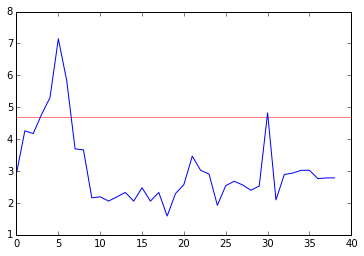

Name of Peptide CSF-1R
Base Energy 27.9868373633
Base Sequence ['N', 'Y', 'Q', 'F', 'C']

 Cycle number : 1

Lowest Energy 1.3090303415 Sequence ['H', 'D', 'K', 'A', 'P']



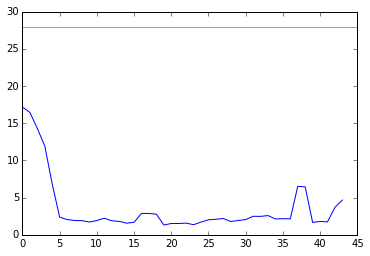

Name of Peptide DDR1
Base Energy 13.1696722075
Base Sequence ['A', 'L', 'N', 'T', 'V']

 Cycle number : 1

Lowest Energy 1.32217193446 Sequence ['R', 'H', 'Q', 'T', 'A']



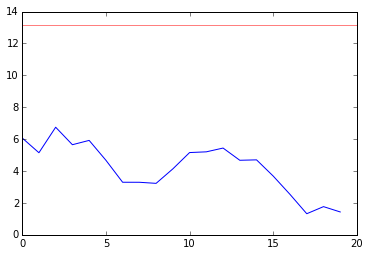

Name of Peptide DDR2
Base Energy 12.924611116
Base Sequence ['Q', 'Q', 'G', 'A', 'E']

 Cycle number : 1

Lowest Energy 1.10644559672 Sequence ['G', 'E', 'C', 'P', 'M']



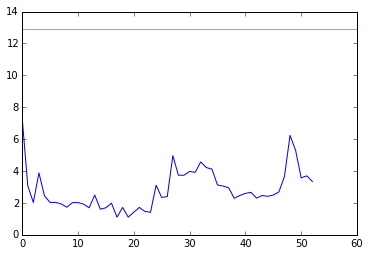

Name of Peptide EGFR
Base Energy 27.164750603
Base Sequence ['E', 'F', 'I', 'G', 'A']

 Cycle number : 1

Lowest Energy 1.29845180082 Sequence ['I', 'E', 'N', 'S', 'W']



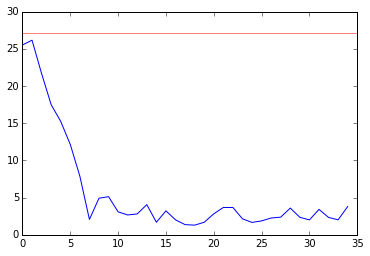

Name of Peptide EphA1
Base Energy 13.7057774191
Base Sequence ['Q', 'G', 'F', 'K', 'D']

 Cycle number : 1

Lowest Energy 1.21413162229 Sequence ['P', 'H', 'E', 'D', 'W']



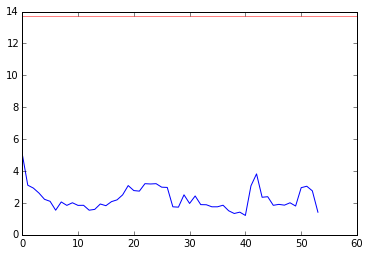

Name of Peptide EphA2
Base Energy 4.35489389959
Base Sequence ['V', 'G', 'I', 'P', 'I']

 Cycle number : 1

Lowest Energy 1.03775212896 Sequence ['P', 'P', 'A', 'D', 'W']



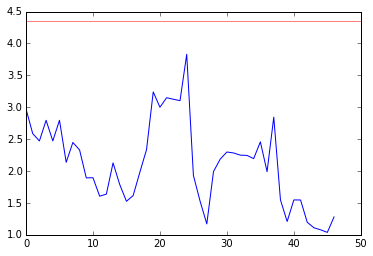

Name of Peptide EphA3
Base Energy 4.9768484043
Base Sequence ['G', 'P', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 0.956117020977 Sequence ['K', 'H', 'G', 'D', 'P']



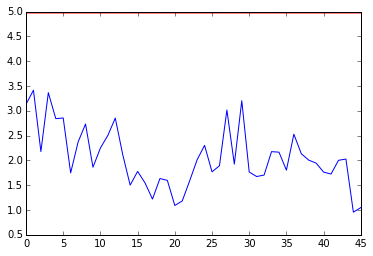

Name of Peptide EphA4
Base Energy 6.93802845937
Base Sequence ['R', 'M', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.46197698226 Sequence ['R', 'P', 'G', 'G', 'P']



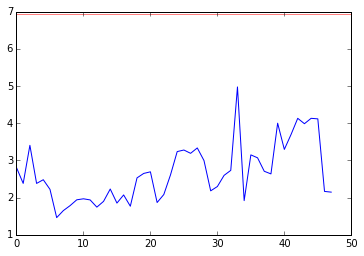

Name of Peptide EphA5
Base Energy 5.94518663308
Base Sequence ['G', 'M', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.20374900774 Sequence ['H', 'H', 'K', 'N', 'V']



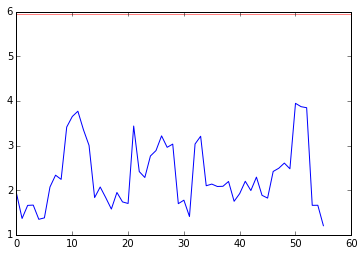

Name of Peptide EphA6
Base Energy 12.9677503712
Base Sequence ['K', 'G', 'F', 'H', 'V']

 Cycle number : 1

Lowest Energy 1.27192380208 Sequence ['H', 'C', 'F', 'A', 'L']



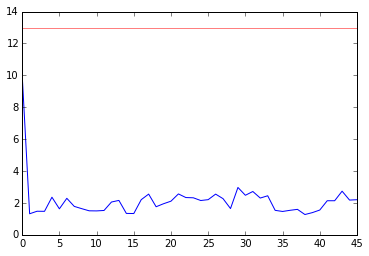

Name of Peptide EphA7_2
Base Energy 42.397382259
Base Sequence ['H', 'L', 'S', 'V', 'L']

 Cycle number : 1

Lowest Energy 1.72564032048 Sequence ['N', 'E', 'P', 'M', 'Y']



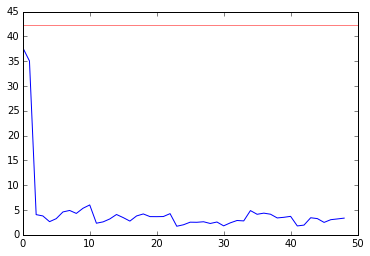

Name of Peptide EphB3
Base Energy 9.15036866847
Base Sequence ['L', 'P', 'V', 'Q', 'V']

 Cycle number : 1

Lowest Energy 2.89665704734 Sequence ['R', 'P', 'G', 'Q', 'M']



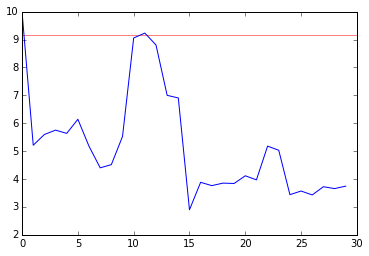

Name of Peptide EphB4
Base Energy 4.43990331423
Base Sequence ['P', 'A', 'Q', 'Q', 'F']

 Cycle number : 1

Lowest Energy 1.33213272745 Sequence ['P', 'G', 'Q', 'V', 'I']



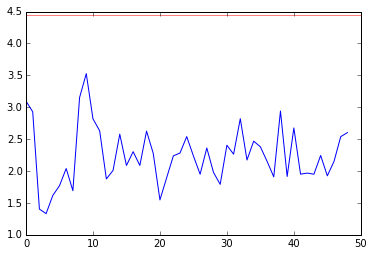

Name of Peptide EphB6_1
Base Energy 4.87191758259
Base Sequence ['G', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 2.27287969841 Sequence ['W', 'S', 'I', 'E', 'P']



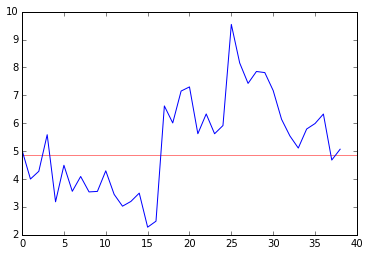

Name of Peptide EphB6_2
Base Energy 7.14839239305
Base Sequence ['R', 'P', 'E', 'V', 'C']

 Cycle number : 1

Lowest Energy 1.33811886784 Sequence ['K', 'G', 'M', 'A', 'N']



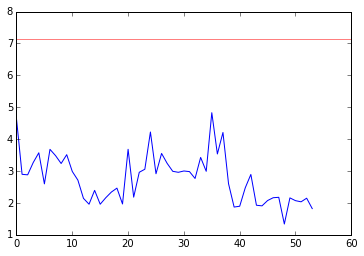

Name of Peptide EphB6_3
Base Energy 9.11135247955
Base Sequence ['S', 'S', 'Q', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.80621834675 Sequence ['C', 'G', 'A', 'S', 'R']



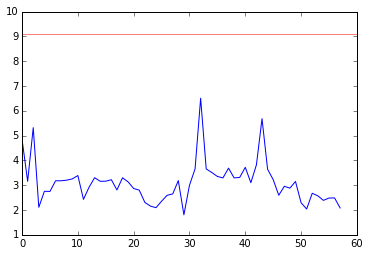

Name of Peptide ErbB2
Base Energy 3.37392946004
Base Sequence ['L', 'D', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 0.973709247015 Sequence ['G', 'E', 'K', 'P', 'V']



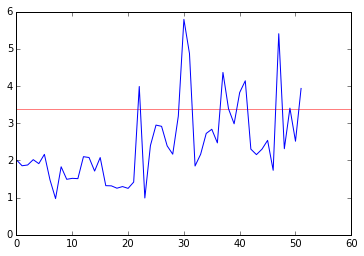

Name of Peptide FGFR2
Base Energy 14.8043063507
Base Sequence ['G', 'S', 'V', 'K', 'T']

 Cycle number : 1

Lowest Energy 1.47706990037 Sequence ['P', 'H', 'Q', 'S', 'M']



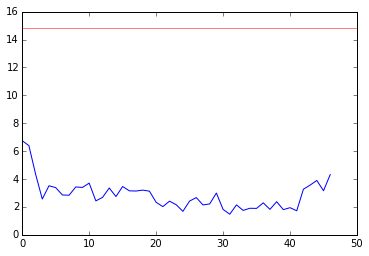

Name of Peptide FGFR3
Base Energy 7.55171969977
Base Sequence ['G', 'G', 'P', 'R', 'T']

 Cycle number : 1

Lowest Energy 1.07619044093 Sequence ['H', 'E', 'V', 'N', 'A']



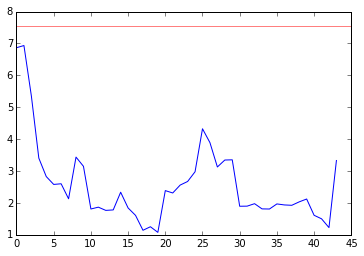

Name of Peptide FGFR4
Base Energy 6.66798799824
Base Sequence ['D', 'S', 'Q', 'T', 'T']

 Cycle number : 1

Lowest Energy 1.59496995307 Sequence ['G', 'D', 'K', 'T', 'A']



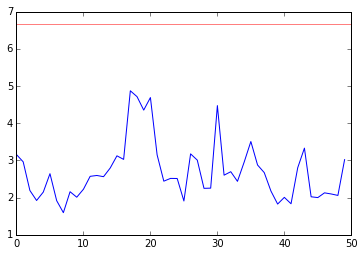

Name of Peptide IRR
Base Energy 2.29432742564
Base Sequence ['G', 'G', 'P', 'G', 'H']

 Cycle number : 1

Lowest Energy 0.937656717255 Sequence ['P', 'Q', 'Q', 'D', 'W']



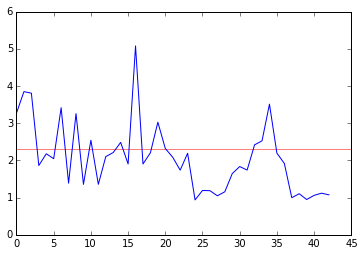

Name of Peptide PDGFRa_1
Base Energy 19.0699112588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 1.11037317135 Sequence ['P', 'D', 'A', 'C', 'A']



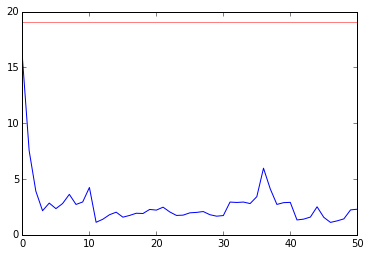

Name of Peptide PDGFRa_2
Base Energy 35.5844940228
Base Sequence ['D', 'L', 'S', 'V', 'V']

 Cycle number : 1

Lowest Energy 1.5083323372 Sequence ['P', 'P', 'A', 'V', 'P']



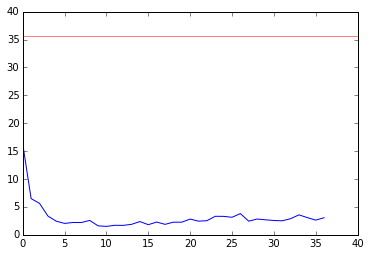

Name of Peptide PTK7
Base Energy 2.51343384822
Base Sequence ['A', 'D', 'S', 'K', 'Q']

 Cycle number : 1

Lowest Energy 1.47675505098 Sequence ['C', 'Q', 'Q', 'N', 'Y']



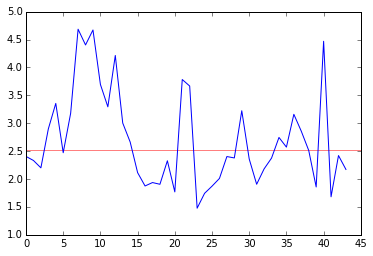

Name of Peptide RET
Base Energy 8.16719510563
Base Sequence ['D', 'T', 'F', 'D', 'S']

 Cycle number : 1

Lowest Energy 1.53049182103 Sequence ['R', 'H', 'P', 'S', 'P']



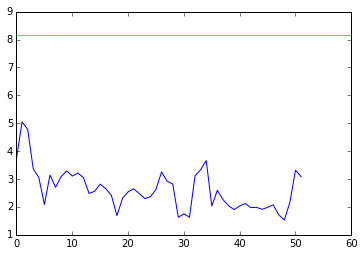

Name of Peptide ROR1
Base Energy 18.9445423206
Base Sequence ['I', 'S', 'A', 'E', 'V']

 Cycle number : 1

Lowest Energy 1.79504425091 Sequence ['I', 'E', 'A', 'C', 'P']



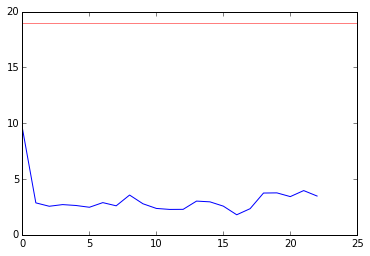

Name of Peptide ROR2
Base Energy 4.80516020003
Base Sequence ['V', 'Q', 'L', 'E', 'A']

 Cycle number : 1

Lowest Energy 0.946296655705 Sequence ['K', 'E', 'K', 'P', 'M']



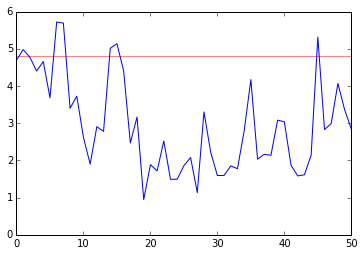

Name of Peptide Ros-1
Base Energy 2.15532631391
Base Sequence ['G', 'D', 'V', 'S', 'E']

 Cycle number : 1

Lowest Energy 1.21249316505 Sequence ['K', 'D', 'I', 'N', 'T']



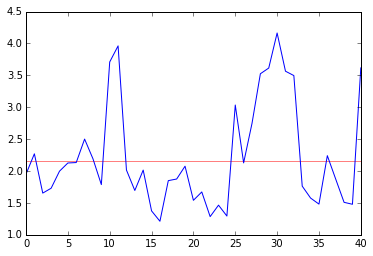

Name of Peptide RYK
Base Energy 32.5043649678
Base Sequence ['L', 'G', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 11.3379663492 Sequence ['L', 'D', 'V', 'F', 'V']



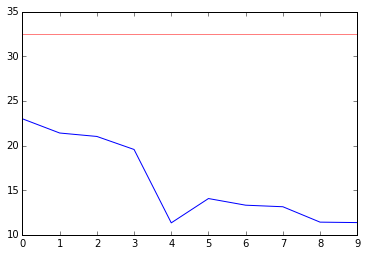

Name of Peptide TIE1
Base Energy 5.76766266737
Base Sequence ['T', 'A', 'E', 'E', 'A']

 Cycle number : 1

Lowest Energy 1.1432900376 Sequence ['K', 'E', 'V', 'P', 'A']



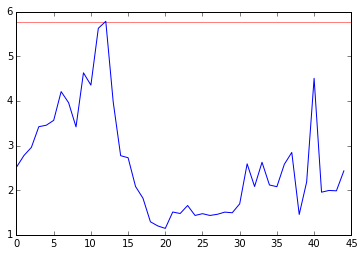

Name of Peptide TIE2
Base Energy 1.69020681995
Base Sequence ['A', 'E', 'E', 'A', 'A']

 Cycle number : 1

Lowest Energy 1.62393472802 Sequence ['C', 'G', 'Q', 'A', 'Y']



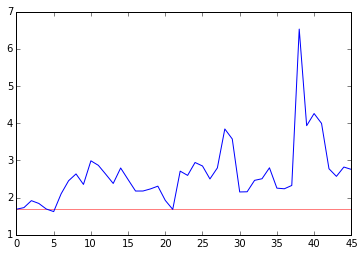

Name of Peptide TrkA
Base Energy 5.16138709518
Base Sequence ['L', 'D', 'V', 'L', 'G']

 Cycle number : 1

Lowest Energy 1.19045882471 Sequence ['K', 'D', 'H', 'D', 'E']



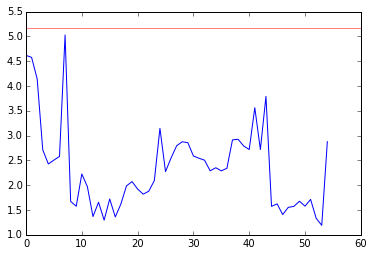

Name of Peptide TYRO3
Base Energy 2.26349868579
Base Sequence ['P', 'H', 'S', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.31247920397 Sequence ['H', 'E', 'P', 'G', 'K']



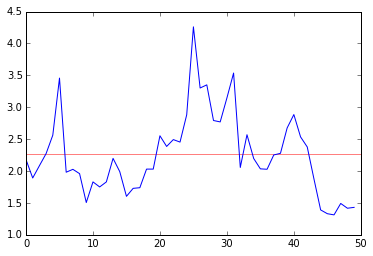

Name of Peptide VEGFR2
Base Energy 7.31991604772
Base Sequence ['R', 'S', 'P', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.49392248768 Sequence ['K', 'G', 'R', 'G', 'N']



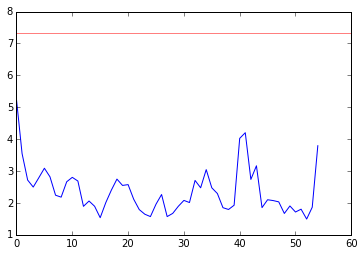

Name of Peptide VEGFR3
Base Energy 2.12671995926
Base Sequence ['A', 'D', 'S', 'S', 'Y']

 Cycle number : 1

Lowest Energy 1.23986083218 Sequence ['K', 'P', 'R', 'T', 'K']



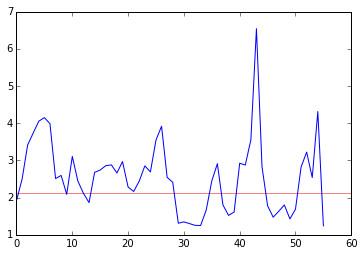

Name of Peptide Sema3a
Base Energy 1.76355662237
Base Sequence ['A', 'P', 'R', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.40626781691 Sequence ['A', 'D', 'R', 'G', 'V']



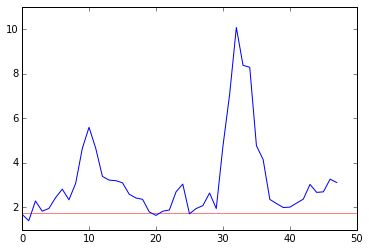

Name of Peptide Sema3b
Base Energy 24.4329755693
Base Sequence ['S', 'A', 'A', 'H', 'W']

 Cycle number : 1

Lowest Energy 1.25125174289 Sequence ['P', 'Q', 'R', 'N', 'F']



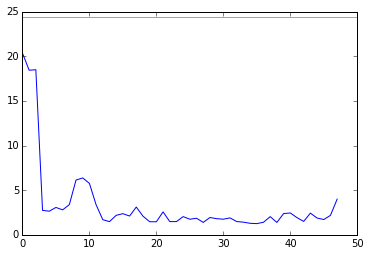

Name of Peptide Sema3f
Base Energy 1.87853901145
Base Sequence ['H', 'P', 'P', 'D', 'T']

 Cycle number : 1

Lowest Energy 1.18198314501 Sequence ['G', 'E', 'G', 'D', 'F']



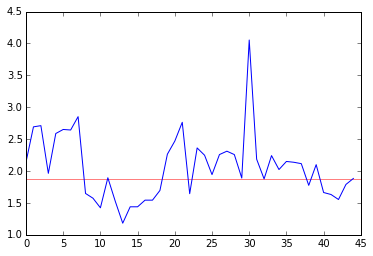

Name of Peptide Sema4a
Base Energy 2.74675035872
Base Sequence ['G', 'A', 'E', 'V', 'A']

 Cycle number : 1

Lowest Energy 1.03595304688 Sequence ['P', 'E', 'A', 'P', 'D']



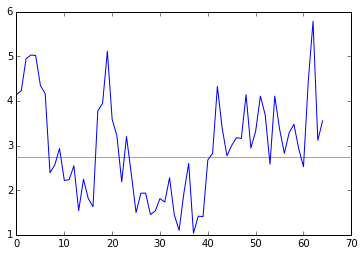

Name of Peptide Sema4b
Base Energy 6.92508036435
Base Sequence ['R', 'D', 'S', 'V', 'V']

 Cycle number : 1

Lowest Energy 8.77810953916 Sequence ['K', 'D', 'S', 'V', 'V']



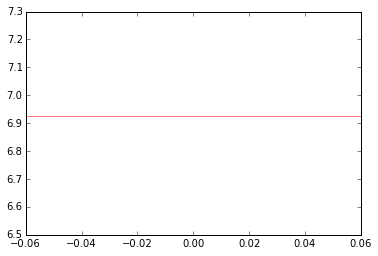

Name of Peptide Sema4c
Base Energy 7.01506486644
Base Sequence ['E', 'E', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 5.7152124254 Sequence ['E', 'E', 'S', 'S', 'G']



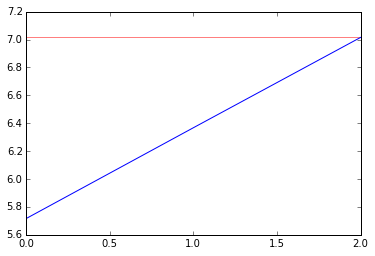

Name of Peptide Sema4f
Base Energy 53.9419732546
Base Sequence ['D', 'E', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 15.8822770823 Sequence ['D', 'E', 'C', 'S', 'I']



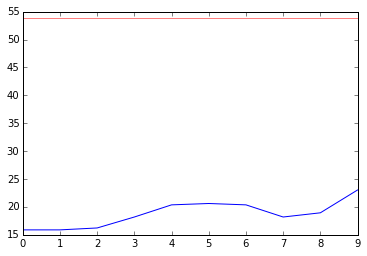

Name of Peptide Sema5a
Base Energy 5.62150826743
Base Sequence ['N', 'Y', 'D', 'E', 'Y']

 Cycle number : 1

Lowest Energy 1.07619044093 Sequence ['H', 'E', 'V', 'N', 'A']



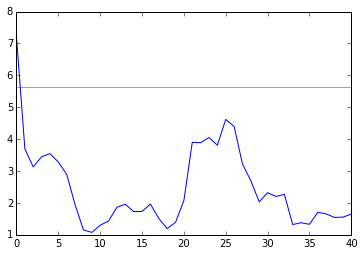

Name of Peptide Sema6a
Base Energy 1.89189243365
Base Sequence ['N', 'D', 'A', 'C', 'T']

 Cycle number : 1

Lowest Energy 1.17900499219 Sequence ['K', 'P', 'R', 'A', 'G']



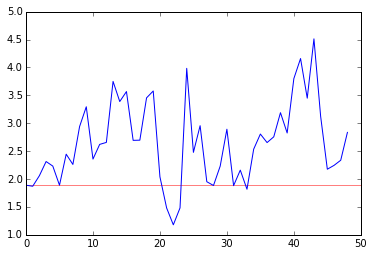

Name of Peptide Sema6b
Base Energy 2.94159456006
Base Sequence ['A', 'P', 'P', 'V', 'P']

 Cycle number : 1

Lowest Energy 1.10395710991 Sequence ['A', 'E', 'P', 'P', 'I']



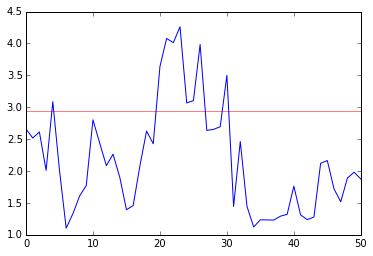

Name of Peptide Sema6c
Base Energy 5.67437897601
Base Sequence ['G', 'H', 'F', 'N', 'F']

 Cycle number : 1

Lowest Energy 4.72383437125 Sequence ['A', 'H', 'L', 'N', 'F']



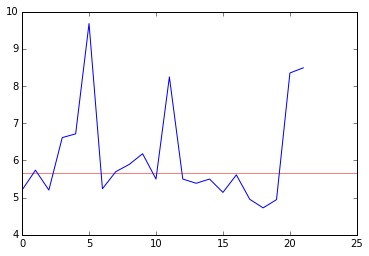

Name of Peptide Nav1.6
Base Energy 3.23100381901
Base Sequence ['R', 'E', 'S', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.17631541685 Sequence ['R', 'E', 'K', 'K', 'C']



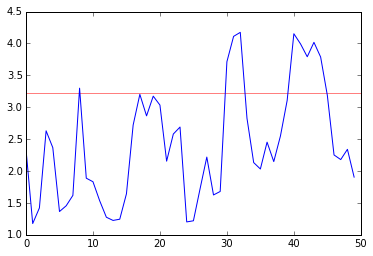

Name of Peptide Nav1.9b
Base Energy 14.835114099
Base Sequence ['K', 'V', 'H', 'C', 'D']

 Cycle number : 1

Lowest Energy 1.25712594934 Sequence ['L', 'E', 'Q', 'G', 'Q']



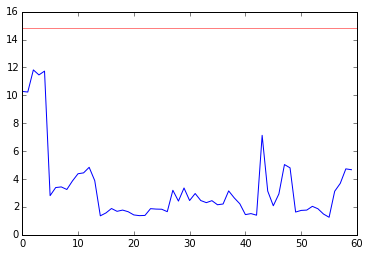

Name of Peptide Nav2
Base Energy 56.9535282708
Base Sequence ['I', 'Q', 'T', 'Q', 'I']

 Cycle number : 1

Lowest Energy 1.9035183002 Sequence ['A', 'Q', 'G', 'D', 'E']



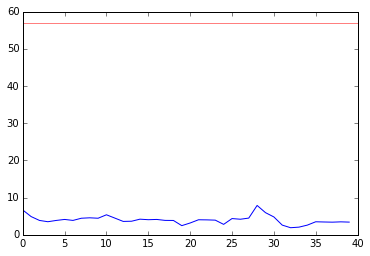

Name of Peptide NHE1
Base Energy 2.22458252069
Base Sequence ['I', 'P', 'K', 'G', 'Q']

 Cycle number : 1

Lowest Energy 0.920545158795 Sequence ['P', 'E', 'Q', 'G', 'Y']



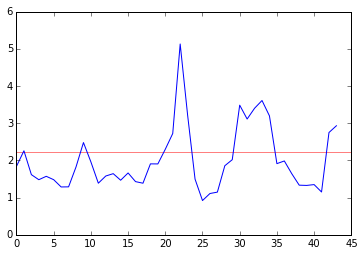

Name of Peptide Syndecan3
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 2.89856866258 Sequence ['E', 'K', 'K', 'D', 'A']



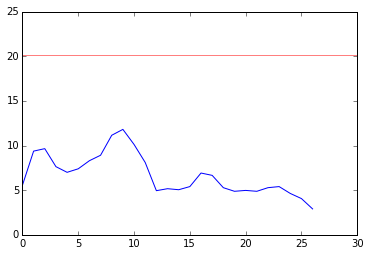

Name of Peptide TRPC1
Base Energy 36.789497232
Base Sequence ['F', 'Y', 'P', 'R', 'N']

 Cycle number : 1

Lowest Energy 1.39719090629 Sequence ['P', 'P', 'Q', 'T', 'E']



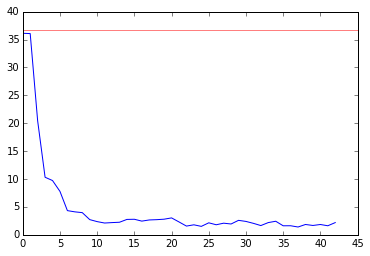

Name of Peptide TRPC2
Base Energy 9.77446519791
Base Sequence ['T', 'K', 'G', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.05495845229 Sequence ['H', 'D', 'G', 'D', 'Y']



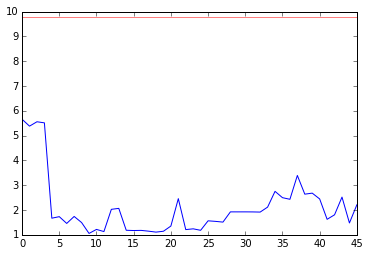

Name of Peptide TRPC3
Base Energy 8.96632131009
Base Sequence ['V', 'L', 'R', 'C', 'E']

 Cycle number : 1

Lowest Energy 1.28064121756 Sequence ['K', 'A', 'K', 'A', 'Q']



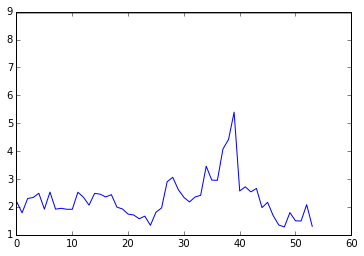

Name of Peptide TRPC5
Base Energy 7.89449491044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 3.79932120776 Sequence ['A', 'T', 'T', 'R', 'P']



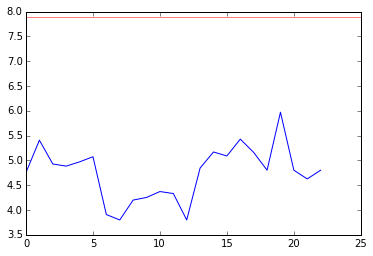

Name of Peptide TRPC6
Base Energy 10.7906794919
Base Sequence ['E', 'E', 'S', 'R', 'R']

 Cycle number : 1

Lowest Energy 1.51032018501 Sequence ['P', 'H', 'C', 'T', 'R']



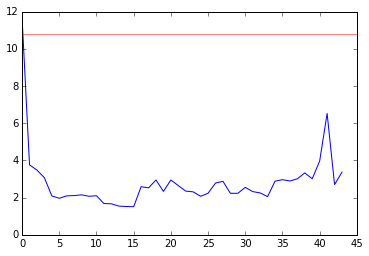

Name of Peptide TRPM3
Base Energy 1.65087662663
Base Sequence ['P', 'F', 'Y', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.55544266409 Sequence ['H', 'M', 'S', 'K', 'G']



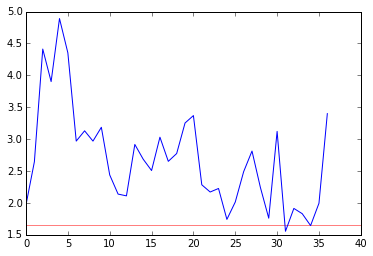

Name of Peptide TRPM4
Base Energy 2.81761761982
Base Sequence ['Q', 'S', 'G', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.61813769803 Sequence ['H', 'D', 'G', 'C', 'N']



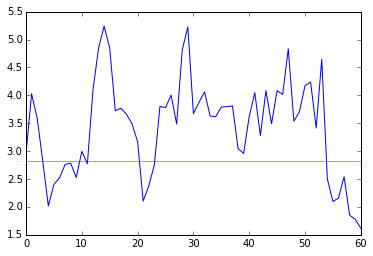

Name of Peptide TRPM5
Base Energy 5.02106119189
Base Sequence ['E', 'T', 'G', 'S', 'T']

 Cycle number : 1

Lowest Energy 1.00317040555 Sequence ['H', 'E', 'C', 'N', 'S']



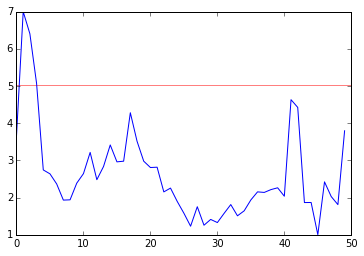

Name of Peptide TRPM6
Base Energy 5.1352907197
Base Sequence ['D', 'H', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 2.00228714919 Sequence ['N', 'H', 'T', 'R', 'W']



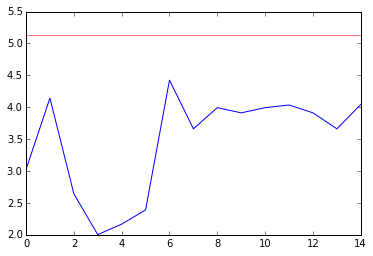

Name of Peptide TRPM7
Base Energy 17.1852674661
Base Sequence ['V', 'R', 'L', 'M', 'L']

 Cycle number : 1

Lowest Energy 1.60035282891 Sequence ['I', 'A', 'Q', 'M', 'W']



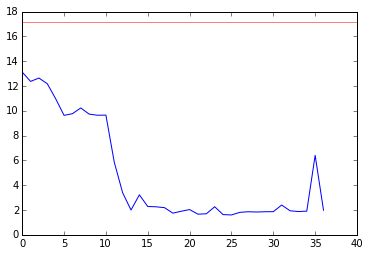

Name of Peptide TRPM8
Base Energy 26.3419147983
Base Sequence ['A', 'N', 'N', 'I', 'K']

 Cycle number : 1

Lowest Energy 1.431883893 Sequence ['R', 'D', 'C', 'N', 'Q']



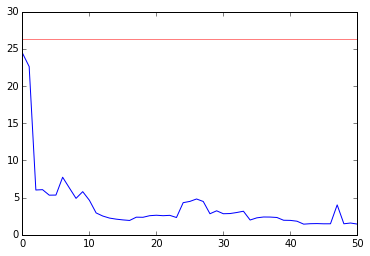

Name of Peptide TRPP2
Base Energy 8.33813906522
Base Sequence ['A', 'N', 'V', 'H', 'A']

 Cycle number : 1

Lowest Energy 1.40729126021 Sequence ['V', 'E', 'E', 'G', 'K']



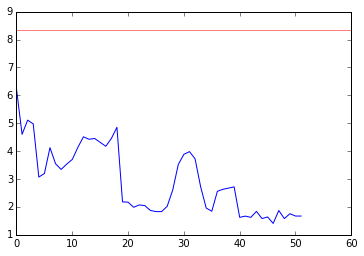

Name of Peptide TRPV3
Base Energy 29.4803613356
Base Sequence ['P', 'E', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 15.2643618007 Sequence ['P', 'E', 'T', 'S', 'C']



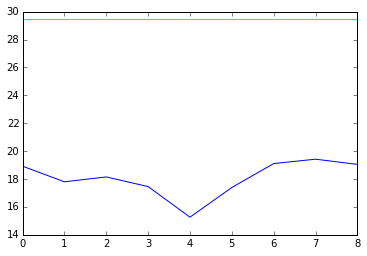

Name of Peptide TRPV4
Base Energy 5.59171498635
Base Sequence ['D', 'D', 'A', 'P', 'L']

 Cycle number : 1

Lowest Energy 1.02426885878 Sequence ['K', 'G', 'P', 'D', 'H']



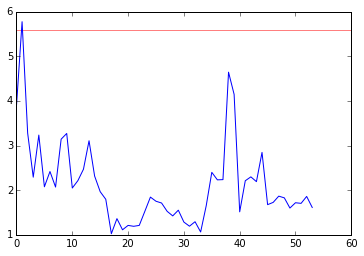

Name of Peptide TRPV6
Base Energy 16.0655743909
Base Sequence ['W', 'E', 'Y', 'Q', 'I']

 Cycle number : 1

Lowest Energy 1.32105148989 Sequence ['R', 'C', 'K', 'N', 'G']



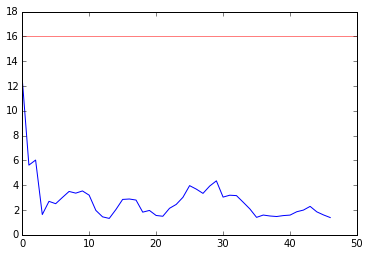

In [205]:
for i in range(len(PDZ_Data.peptides)):
    results = run_mc(100, PDZ_Data.peptides[i], temp=1.0,nb_cycles = 1, plot=True, verbose=False)

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 1.00987706207 Sequence ['V', 'M', 'I', 'W', 'K']



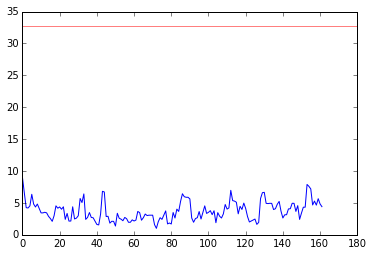


 Cycle number : 2

Lowest Energy 1.4105537934 Sequence ['F', 'D', 'N', 'V', 'Y']



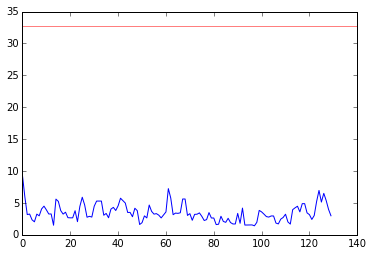


 Cycle number : 3

Lowest Energy 1.30464947057 Sequence ['E', 'V', 'G', 'C', 'D']



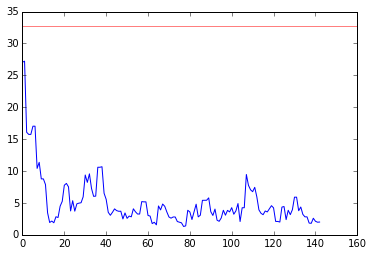


 Cycle number : 4

Lowest Energy 1.35336918126 Sequence ['H', 'E', 'I', 'V', 'T']



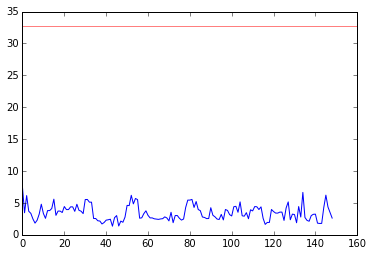


 Cycle number : 5

Lowest Energy 1.14937374501 Sequence ['W', 'G', 'K', 'T', 'G']



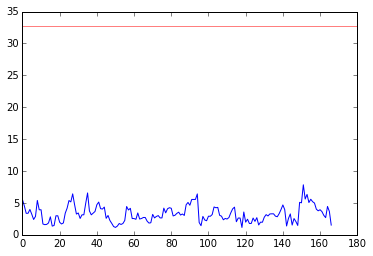


 Cycle number : 6

Lowest Energy 1.22718030488 Sequence ['F', 'C', 'G', 'P', 'H']



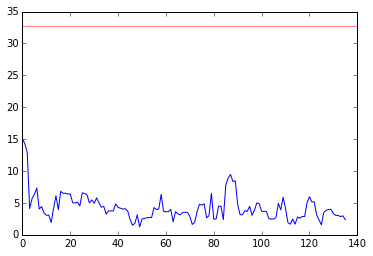


 Cycle number : 7

Lowest Energy 0.929380764227 Sequence ['F', 'D', 'L', 'M', 'C']



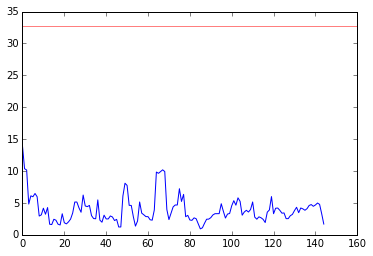


 Cycle number : 8

Lowest Energy 1.29358928891 Sequence ['I', 'T', 'R', 'I', 'C']



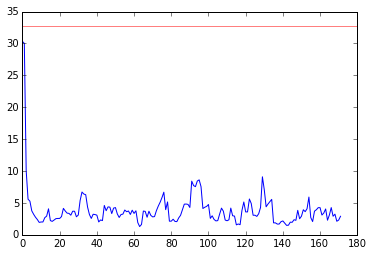


 Cycle number : 9

Lowest Energy 1.48562932369 Sequence ['N', 'N', 'K', 'F', 'A']



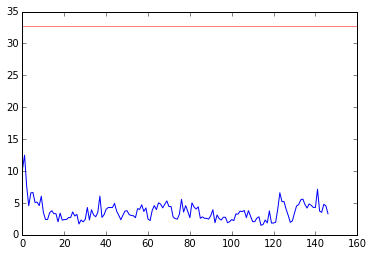


 Cycle number : 10

Lowest Energy 1.35727379316 Sequence ['W', 'K', 'K', 'W', 'P']



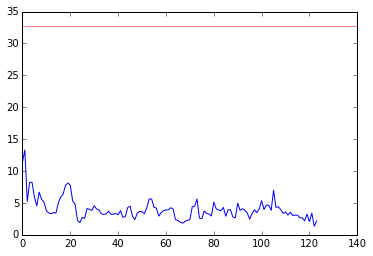

In [139]:
demo = run_mc(1000, PDZ_Data.peptides[0], temp = 1.0,nb_cycles=10, plot = True, verbose = False)

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Run number: 0

Uniform 0.402933962786 Ratio 33718.0051089 Prob_Trans 1 
Accepted [17, 3, 9, 9, 2] 24.2622310541 ['H', 'L', 'S', 'S', 'V'] 

Run number: 1

Uniform 0.180680861769 Ratio 1151.18421626 Prob_Trans 1 
Accepted [17, 3, 9, 19, 2] 17.2136846093 ['H', 'L', 'S', 'E', 'V'] 

Run number: 3

Uniform 0.25779016607 Ratio 7.84728396218 Prob_Trans 1 
Accepted [17, 3, 9, 2, 16] 15.1535171295 ['H', 'L', 'S', 'V', 'R'] 

Run number: 4

Uniform 0.83025861913 Ratio 111.214766435 Prob_Trans 1 
Accepted [17, 3, 9, 19, 16] 10.4420539648 ['H', 'L', 'S', 'E', 'R'] 

Run number: 62

Uniform 0.0704017709011 Ratio 0.625697670593 Prob_Trans 0.625697670593 
Accepted [15, 3, 6, 15, 12] 10.9109419437 ['K', 'L', 'P', 'K', 'Q'] 

Run number: 63

Uniform 0.150897117364 Ratio 1.35275539542 Prob_Trans 1 
Accepted [15, 3, 6, 15, 16] 10.6087983976 ['K', 'L', 'P', 'K', 'R'] 

Run number: 71

Uniform 0

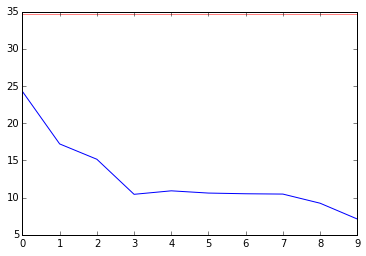

In [140]:
demo2 = run_mc(100, PDZ_Data.peptides[2], temp = 1.0, nb_cycles=1, plot=True, verbose=True)

In [141]:
len(demo2)

1

In [145]:
energies = demo2[0]['Mutated Energies']
sequences = demo2[0]['Mutated sequences']

In [146]:
energies[0:5]

[24.262231054107019,
 17.213684609311393,
 25.10791820834844,
 15.153517129465753,
 10.442053964785746]

In [149]:
res = demo2[0]['Results']

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Last sequence seen [2, 3, 9, 9, 2]
Sequence after mutation [2, 3, 9, 6, 2]
Run number: 0

Uniform 0.421224174798 Ratio 25854664.3767 Prob_Trans 1 
Accepted [2, 3, 9, 6, 2] 17.6200167213 ['V', 'L', 'S', 'P', 'V'] ['V', 'L', 'S', 'P', 'V'] 

Last sequence seen [2, 3, 9, 6, 2]
Sequence after mutation [2, 3, 9, 19, 2]
Run number: 1

Uniform 0.320969769861 Ratio 7.68420839119e-06 Prob_Trans 7.68420839119e-06 
Rejected [2, 3, 9, 19, 2] 29.3963599145 ['V', 'L', 'S', 'E', 'V'] ['V', 'L', 'S', 'P', 'V']

Last sequence seen [2, 3, 9, 6, 2]
Sequence after mutation [2, 13, 9, 6, 2]
Run number: 2

Uniform 0.919276464446 Ratio 0.750495466035 Prob_Trans 0.750495466035 
Rejected [2, 13, 9, 6, 2] 17.9070383904 ['V', 'Y', 'S', 'P', 'V'] ['V', 'L', 'S', 'P', 'V']

Last sequence seen [2, 3, 9, 6, 2]
Sequence after mutation [15, 3, 9, 6, 2]
Run number: 3

Uniform 0.248968835807 Ratio 0.0030239606

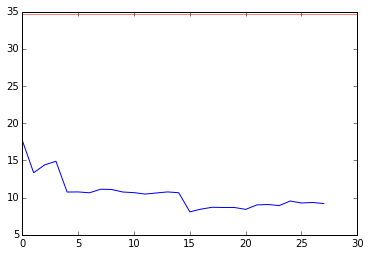

In [184]:
demo3 = run_mc(100, PDZ_Data.peptides[2], temp = 1.0, nb_cycles=1, plot=True, verbose=True)

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Run number: 76

Uniform 0.02643502242 Ratio 0.0622045982791 Prob_Trans 0.0622045982791 
Accepted [2, 19, 10, 17, 2] 9.6935140631 ['V', 'E', 'T', 'H', 'V'] ['V', 'E', 'T', 'H', 'V'] 

Run number: 113

Uniform 0.385032340613 Ratio 0.833861109232 Prob_Trans 0.833861109232 
Accepted [15, 19, 10, 17, 2] 9.87520248928 ['K', 'E', 'T', 'H', 'V'] ['K', 'E', 'T', 'H', 'V'] 

Run number: 137

Uniform 0.538084173701 Ratio 0.907373328598 Prob_Trans 0.907373328598 
Accepted [17, 19, 10, 17, 2] 9.97240379468 ['H', 'E', 'T', 'H', 'V'] ['H', 'E', 'T', 'H', 'V'] 

Run number: 158

Uniform 0.0125974140428 Ratio 0.523212868776 Prob_Trans 0.523212868776 
Accepted [16, 19, 10, 17, 2] 10.6201706775 ['R', 'E', 'T', 'H', 'V'] ['R', 'E', 'T', 'H', 'V'] 

Run number: 169

Uniform 0.620346292591 Ratio 2.52604948612 Prob_Trans 1 
Accepted [2, 19, 10, 17, 2] 9.6935140631 ['V', 'E', 'T', 'H', 'V'] ['V', 'E', 

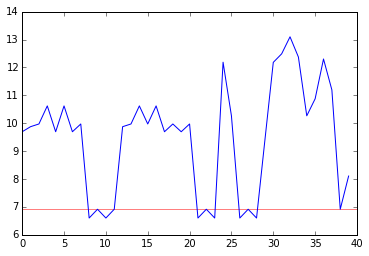

In [213]:
demo4 = run_mc(1000, test_peptide2, temp=1.0, nb_cycles = 1, plot = True, verbose=True)

In [195]:
sequences = demo4[0]['Mutated sequences']

In [196]:
results = demo4[0]['Results']

In [197]:
results

[{'Energy': 1.648426538659882,
  'Sequence': [12, 17, 19, 18, 1],
  'Status': 'Accepted'},
 {'Energy': 2.224858348378087,
  'Sequence': [10, 17, 19, 18, 1],
  'Status': 'Rejected'},
 {'Energy': 22.970671382000891,
  'Sequence': [12, 17, 19, 16, 1],
  'Status': 'Rejected'},
 {'Energy': 1.2810752558320997,
  'Sequence': [6, 17, 19, 18, 1],
  'Status': 'Accepted'},
 {'Energy': 1.0512886267410169,
  'Sequence': [6, 12, 19, 18, 1],
  'Status': 'Accepted'},
 {'Energy': 1.1907239596765229,
  'Sequence': [6, 12, 19, 18, 11],
  'Status': 'Accepted'},
 {'Energy': 1.562124388664724,
  'Sequence': [6, 17, 19, 18, 11],
  'Status': 'Rejected'},
 {'Energy': 2.2679927649660829,
  'Sequence': [6, 10, 19, 18, 11],
  'Status': 'Rejected'},
 {'Energy': 1.9974971913921564,
  'Sequence': [6, 12, 19, 6, 11],
  'Status': 'Rejected'},
 {'Energy': 13.500606656245875,
  'Sequence': [7, 12, 19, 18, 11],
  'Status': 'Rejected'},
 {'Energy': 12.368770590001725,
  'Sequence': [6, 2, 19, 18, 11],
  'Status': 'Rejecte